In [1]:
import os
import sys
import scipy
import pandas as pd
from adjustText import adjust_text
from scipy.sparse import identity
from pathlib import Path
from scipy.stats import pearsonr
from scipy.stats import ttest_rel, chi2_contingency
from adjustText import adjust_text
import numpy as np
import networkx as nx
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
from analysis.topology_analysis import load_network_data, analyze_topological_features
from analysis.roi_utils import normalize_roi_name

# Add src directory to Python path
project_root = Path.cwd()
src_path = str(project_root / "DomiRank" / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Now should be able to import like this
try:
    from DomiRank import domirank  # Note importing directly from src
    from utils.NetworkUtils import generate_attack, network_attack_sampled
    print("Successfully imported all modules")
except ImportError as e:
    print(f"Import error: {e}")

Successfully imported all modules


In [2]:
def threshold_matrix(matrix, percentile):
    """Threshold matrix (enhanced version)"""
    if matrix.size == 0:
        return matrix
        
    # Ensure matrix has valid values
    if np.isnan(matrix).any():
        matrix = np.nan_to_num(matrix, nan=0.0)
        
    # Calculate threshold
    if np.all(matrix == 0):
        return matrix
        
    threshold = np.percentile(matrix[matrix > 0], percentile) if np.any(matrix > 0) else 0
    binary_matrix = (matrix >= threshold).astype(float)
    return binary_matrix * matrix  # Maintain original values but filter connections below threshold

In [3]:
def compute_domirank_metrics(adj_matrix):
    """
    Compute DomiRank centrality metrics (updated version)
    """
    # Convert to sparse matrix if not already
    if isinstance(adj_matrix, np.ndarray):
        adj_matrix = scipy.sparse.csr_matrix(adj_matrix)
    elif not scipy.sparse.issparse(adj_matrix):
        raise ValueError("Input must be numpy array or scipy sparse matrix")
        
    # Ensure matrix is not empty and contains no NaN values
    if adj_matrix.size == 0 or np.isnan(adj_matrix.data).any():
        raise ValueError("Input matrix is empty or contains NaN values")
        
    # Create graph for additional metrics calculation
    G = nx.from_scipy_sparse_array(adj_matrix, create_using=nx.DiGraph)
    
    # Ensure graph is not empty
    if G.number_of_nodes() == 0:
        raise ValueError("Created graph is empty")
        
    # Compute DomiRank
    success, dominance = domirank(adj_matrix)
    if not success:
        raise RuntimeError("DomiRank computation did not converge")
        
    return {
        'domirank': dominance,
        'mean_dominance': np.mean(dominance),
        'std_dominance': np.std(dominance),
        'degree_centrality': np.array(list(nx.degree_centrality(G).values())),
        'betweenness': np.array(list(nx.betweenness_centrality(G).values())),
        'graph': G
    }

In [4]:
def analyze_domirank_features(data, percentile=98.25):
    """Modified DomiRank analysis workflow that averages trial matrices first"""
    if not data or 'rest' not in data or not data['rest']:
        raise ValueError("Input data format incorrect or empty")
    
    results = {
        'rest': defaultdict(dict),
        'conditions': defaultdict(dict),
        'comparisons': defaultdict(dict),
        'roi_names': data.get('roi_names', [f'ROI_{i}' for i in range(data['rest'][next(iter(data['rest']))][0].shape[0])])
    }
    
    def process_matrix(matrices, condition_name="", source_name=""):
        """Process matrices by averaging trials first"""
        print(f"\nProcessing {condition_name} - Source: {source_name} ({len(matrices)} trials)")
        
        try:
            # 1. Average trial matrices first
            print("Averaging trial matrices...", end=" ", flush=True)
            avg_matrix = np.nanmean(matrices, axis=0)
            print("Done")
            
            # 2. Apply threshold to averaged matrix
            print("Thresholding averaged matrix...", end=" ", flush=True)
            thresholded = threshold_matrix(avg_matrix, percentile)
            print("Done")
            
            # 3. Compute DomiRank metrics
            print("Computing DomiRank metrics...", end=" ", flush=True)
            metrics = compute_domirank_metrics(thresholded)
            print("Done")
            
            # Add additional info
            metrics['n_trials'] = len(matrices)
            metrics['avg_matrix'] = avg_matrix  # Save averaged matrix
            metrics['thresholded_matrix'] = thresholded  # Save thresholded matrix
            
            return metrics
            
        except Exception as e:
            print(f"\nError processing {condition_name} - {source_name}: {str(e)}")
            raise
            
    # Process all conditions
    print("\n" + "="*50)
    print("Processing Rest condition")
    print("="*50)
    for source, matrices in data['rest'].items():
        results['rest'][source] = process_matrix(matrices, "Rest", source)
    
    # Process experimental conditions
    for cond, source_dict in data['conditions'].items():
        print("\n" + "="*50)
        print(f"Processing condition: {cond}")
        print("="*50)
        
        for source, matrices in source_dict.items():
            results['conditions'][cond][source] = process_matrix(matrices, cond, source)
    
    # Comparison analysis
    print("\n" + "="*50)
    print("Performing condition comparisons")
    print("="*50)
    for cond in data['conditions']:
        common_sources = set(results['rest'].keys()) & set(results['conditions'][cond].keys())
        print(f"\nComparing Rest vs {cond} (common sources: {len(common_sources)})")
        
        diffs = [
            results['conditions'][cond][src]['mean_dominance'] - results['rest'][src]['mean_dominance']
            for src in common_sources
            if not np.isnan(results['rest'][src]['mean_dominance'])
        ]
        
        results['comparisons'][cond] = {
            'dominance_diff': diffs,
            'mean_diff': np.nanmean(diffs) if diffs else np.nan,
            'std_diff': np.nanstd(diffs) if diffs else np.nan,
            'n_sources': len(common_sources),
            'common_sources': list(common_sources)
        }
        
        print(f"  Mean dominance difference: {results['comparisons'][cond]['mean_diff']:.4f}")
        print(f"  STD of differences: {results['comparisons'][cond]['std_diff']:.4f}")
    
    print("\n" + "="*50)
    print("Analysis complete!")
    print("="*50)
    return results

In [5]:
# 1. Load data
print("\n>>> Step 1: Loading network data <<<")
network_data = load_network_data(results_folder='results', network_type='TE', atom_type='xty')

# 3. DomiRank analysis
print("\n>>> Step 3: Performing DomiRank analysis <<<")
domirank_results = analyze_domirank_features(network_data, percentile=98.25)



>>> Step 1: Loading network data <<<

Starting network data loading
Results folder: results
Network type: TE
Atom type: xty

Found 10 result files:
  1. results_Rest.pkl
  2. results_VISp (L).pkl
  3. results_SSp-ul_ll (R).pkl
  4. results_VISa_rl (R).pkl
  5. results_RSPd_v (Bilateral).pkl
  ... (Total 10 files)

Processing file 1/10: results_AUD (L).pkl
Condition name: AUD (L)
Number of ROIs: 130
First 5 ROI names: ['FRP (R)', 'ACAd (R)', 'ACAv (R)', 'PL (R)', 'ILA (R)']
Number of ROI pairs: 16770
Identified as experimental condition: AUD (L)
Loaded sources: 8
  source '2': 14 matrices
  source '4': 14 matrices
  source '6': 14 matrices
  ... (Total 8 sources)

Processing file 2/10: results_MOp (L).pkl
Condition name: MOp (L)
Number of ROI pairs: 16770
Identified as experimental condition: MOp (L)
Loaded sources: 7
  source '2': 7 matrices
  source '6': 7 matrices
  source '3': 7 matrices
  ... (Total 7 sources)

Processing file 3/10: results_MOs (R).pkl
Condition name: MOs (R)
Numb

Exception ignored in atexit callback <function _exit_function at 0x100ed6c00>:
Traceback (most recent call last):
  File "/Users/alinatu/miniconda3/lib/python3.13/multiprocessing/util.py", line 326, in _exit_function
Process Process-239:
Process Process-256:
Process Process-252:
Process Process-248:
Process Process-247:
Exception ignored in atexit callback <function _exit_function at 0x101b82c00>:
Traceback (most recent call last):
  File "/Users/alinatu/miniconda3/lib/python3.13/multiprocessing/util.py", line 352, in _exit_function
Exception ignored in atexit callback <function _exit_function at 0x10384ac00>:
Traceback (most recent call last):
  File "/Users/alinatu/miniconda3/lib/python3.13/multiprocessing/util.py", line 326, in _exit_function
    _run_finalizers()
  File "/Users/alinatu/miniconda3/lib/python3.13/multiprocessing/util.py", line 292, in _run_finalizers
    _run_finalizers(0)
  File "/Users/alinatu/miniconda3/lib/python3.13/multiprocessing/util.py", line 292, in _run_fi

KeyboardInterrupt: 

In [ ]:
# Export results
import pickle
with open('domirank_results.pkl', 'wb') as f:
	pickle.dump(domirank_results, f)

# Generating Plots

In [ ]:
def plot_domirank_results(results, network_type='TE'):
    """Visualization using Seaborn with improved heatmap formatting"""
    plt.figure(figsize=(18, 6))
    sns.set(style="whitegrid", font_scale=1.1)
    
    # 1. Dominance distribution comparison (includes Rest)
    plot_data = []
    
    # Collect Rest data
    if results['rest']:
        for src, metrics in results['rest'].items():
            plot_data.append({
                'Condition': 'Rest',
                'Dominance': metrics['mean_dominance'],
                'Source': src,
                'Type': 'Raw'
            })
    
    # Collect non-Rest condition data
    for cond in results['conditions']:
        if cond.lower() != 'rest':
            for src, metrics in results['conditions'][cond].items():
                plot_data.append({
                    'Condition': cond,
                    'Dominance': metrics['mean_dominance'],
                    'Source': src,
                    'Type': 'Raw'
                })
    
    # Convert to DataFrame and plot
    df = pd.DataFrame(plot_data)
    sns.boxplot(data=df, x='Condition', y='Dominance', 
                palette='viridis',
                width=0.6, order=['Rest'] + sorted([c for c in df['Condition'].unique() if c != 'Rest']))
    sns.stripplot(data=df, x='Condition', y='Dominance',
                  color='black', alpha=0.5, jitter=0.2, size=5,
                  order=['Rest'] + sorted([c for c in df['Condition'].unique() if c != 'Rest']))
    plt.ylabel('Dominance Score')
    plt.xticks(rotation=45)
    plt.savefig('network_dominance.pdf', bbox_inches='tight')
    plt.close()
    
    # 2. Difference statistics
    plt.figure(figsize=(18, 6))
    cond_names = [cond for cond in results['comparisons'] if cond.lower() != 'rest']
    
    # Prepare difference data with FDR correction
    diff_data = []
    p_values = []
    common_sources_counts = []
    
    for cond in cond_names:
        common_sources = results['comparisons'][cond].get('common_sources', [])
        common_sources_counts.append(len(common_sources))
        
        paired_rest = []
        paired_cond = []
        
        for src in common_sources:
            if src in results['rest'] and src in results['conditions'][cond]:
                paired_rest.append(results['rest'][src]['mean_dominance'])
                paired_cond.append(results['conditions'][cond][src]['mean_dominance'])
        
        diffs = [c - r for c, r in zip(paired_cond, paired_rest)]
        diff_data.append(diffs)
        
        if len(paired_rest) > 1 and len(paired_cond) > 1:
            t_stat, p_val = ttest_rel(paired_cond, paired_rest)
            p_values.append(p_val)
        else:
            p_values.append(np.nan)
    
    # Apply FDR correction
    from statsmodels.stats.multitest import multipletests
    rejected, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    
    # Prepare difference dataframe
    diff_df = pd.DataFrame({
        'Condition': np.repeat(cond_names, [len(d) for d in diff_data]),
        'Dominance Difference': np.concatenate(diff_data)
    })
    
    # Plot with corrected p-values
    sns.boxplot(data=diff_df, x='Condition', y='Dominance Difference',
                palette='viridis', width=0.6)
    sns.stripplot(data=diff_df, x='Condition', y='Dominance Difference',
                  color='black', alpha=0.5, jitter=0.2, size=5)
    
    # Add FDR-corrected p-values
    if not diff_df.empty:
        y_max = diff_df['Dominance Difference'].max() * 1.1
        for i, (p_val, n) in enumerate(zip(pvals_corrected, common_sources_counts)):
            x_pos = i
            plt.text(x_pos, y_max, f"p={p_val:.3f}", 
                    ha='center', va='bottom', color='grey', fontsize=10)
    
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel('Δ Dominance (Condition - Rest)')
    plt.ylim(top=y_max*1.4)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('dominance_diff.pdf', bbox_inches='tight')
    plt.close()
    
    # 3. Condition vs Condition comparison heatmap with improved formatting
    plt.figure(figsize=(7, 6))
    sns.set(font_scale=1.1)
    
    conditions = ['Rest'] + list(results['conditions'].keys())
    n_conditions = len(conditions)
    
    # Initialize matrices
    diff_matrix = np.zeros((n_conditions, n_conditions))
    p_matrix = np.zeros((n_conditions, n_conditions))
    p_values = []
    
    # Collect all p-values for FDR correction
    for i, cond1 in enumerate(conditions):
        for j, cond2 in enumerate(conditions):
            if i < j:
                if cond1 == 'Rest':
                    sources1 = results['rest'].keys()
                    data1 = results['rest']
                else:
                    sources1 = results['conditions'][cond1].keys()
                    data1 = results['conditions'][cond1]
                
                if cond2 == 'Rest':
                    sources2 = results['rest'].keys()
                    data2 = results['rest']
                else:
                    sources2 = results['conditions'][cond2].keys()
                    data2 = results['conditions'][cond2]
                
                common_sources = set(sources1) & set(sources2)
                
                if len(common_sources) > 1:
                    cond1_dom = []
                    cond2_dom = []
                    for src in common_sources:
                        cond1_dom.append(data1[src]['mean_dominance'])
                        cond2_dom.append(data2[src]['mean_dominance'])
                    
                    mean_diff = np.mean(np.array(cond2_dom) - np.array(cond1_dom)) * 100
                    diff_matrix[i, j] = mean_diff
                    diff_matrix[j, i] = mean_diff
                    
                    _, p_val = ttest_rel(cond2_dom, cond1_dom)
                    p_matrix[i, j] = p_val
                    p_matrix[j, i] = p_val
                    p_values.append(p_val)
    
    # Apply FDR correction
    if p_values:
        rejected, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    
    # Create annotation matrices with corrected p-values
    signif_matrix = np.empty((n_conditions, n_conditions), dtype=object)
    p_idx = 0
    for i in range(n_conditions):
        for j in range(n_conditions):
            if i == j:
                signif_matrix[i,j] = ""
            elif i < j:
                p_corrected = pvals_corrected[p_idx]
                if p_corrected < 0.001:
                    signif_str = f"{-np.log10(p_corrected):.1f}"
                else:
                    signif_str = f"{-np.log10(p_corrected):.2f}"
                signif_matrix[i,j] = signif_str
                p_idx += 1
    
    # Create masks
    mask_upper = np.triu(np.ones_like(diff_matrix, dtype=bool))  # Upper triangle mask
    
    # Plot main heatmap (lower triangle)
    ax = sns.heatmap(
        diff_matrix, 
        annot=False,  # We'll add annotations manually
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        mask=mask_upper,  # Show lower triangle
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Δ Mean Dominance (10^-2)'},
        square=True,
        xticklabels=conditions,
        yticklabels=conditions
    )
    
    # Function to determine text color based on background brightness
    def get_text_color(value, cmap, vmin, vmax):
        """Return 'white' for dark backgrounds, 'black' for light"""
        norm = plt.Normalize(vmin, vmax)
        rgb = cmap(norm(value))[:3]  # Get RGB values
        brightness = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
        return 'white' if brightness < 0.6 else 'black'
    
    # Add similarity values to lower triangle with adaptive colors
    for i in range(n_conditions):
        for j in range(n_conditions):
            if i > j:  # Lower triangle
                value = diff_matrix[i,j]
                text_color = get_text_color(value, plt.get_cmap('coolwarm'), -np.max(np.abs(diff_matrix)), np.max(np.abs(diff_matrix)))
                ax.text(j+0.5, i+0.5, f"{value:.2f}", 
                       ha='center', va='center', 
                       color=text_color, 
                       fontsize=10,
                       fontweight='bold' if text_color == 'white' else 'normal')
    
    # Create background matrix for significance
    bg_matrix = np.zeros((n_conditions, n_conditions))
    p_idx = 0
    sig_threshold = 0.05
    for i in range(n_conditions):
        for j in range(n_conditions):
            if i < j:
                p_corrected = pvals_corrected[p_idx]
                if p_corrected < sig_threshold:
                    bg_matrix[i,j] = -np.log10(p_corrected)
                else:
                    bg_matrix[i,j] = -1  # Non-significant
                p_idx += 1
    
    # Normalize significant values
    sig_values = bg_matrix[bg_matrix > 0]
    if len(sig_values) > 0:
        max_sig = np.max(sig_values)
        min_sig = np.min(sig_values)
        bg_matrix[bg_matrix > 0] = (bg_matrix[bg_matrix > 0] - min_sig) / (max_sig - min_sig)
    
    # Plot significance backgrounds and annotations
    bg_cmap = plt.cm.YlOrBr
    for i in range(n_conditions):
        for j in range(n_conditions):
            if i < j:  # Upper triangle
                if bg_matrix[i,j] == -1:
                    # Non-significant - grey background with black text
                    bg_color = (0.9, 0.9, 0.9)
                    text_color = 'black'
                else:
                    # Significant - colored background
                    bg_color = bg_cmap(bg_matrix[i,j])
                    brightness = 0.299*bg_color[0] + 0.587*bg_color[1] + 0.114*bg_color[2]
                    text_color = 'white' if brightness < 0.6 else 'black'
                
                # Add background
                rect = plt.Rectangle((j, i), 1, 1, fill=True, 
                                    color=bg_color, 
                                    linewidth=0, edgecolor='gray')
                ax.add_patch(rect)
                
                # Add text
                ax.text(j+0.5, i+0.5, signif_matrix[i,j], 
                       ha='center', va='center', 
                       color=text_color, 
                       fontsize=10,
                       fontweight='bold' if text_color == 'white' else 'normal')
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Add significance colorbar
    if len(sig_values) > 0:
        sm = plt.cm.ScalarMappable(cmap=bg_cmap, 
                                  norm=plt.Normalize(vmin=min_sig, vmax=max_sig))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.02)
        cbar.set_label('-log10(FDR p)')
    
    plt.savefig('condition_comparison_heatmap.pdf', bbox_inches='tight')
    plt.show()

    # Print statistical results with FDR correction
    print("\nStatistical Results (Paired t-test vs Rest with FDR correction):")
    print("-"*70)
    print(f"{'Condition':20s}{'N Pairs':10s}{'Raw p':15s}{'FDR p':15s}{'Sig.'}")
    print("-"*70)
    for cond, p_val, p_corrected, n in zip(cond_names, p_values, pvals_corrected, common_sources_counts):
        sig = 'Yes' if p_corrected < 0.05 else 'No'
        p_val_str = f"{p_val:.4f}" if not np.isnan(p_val) else "N/A"
        p_corr_str = f"{p_corrected:.4f}" if not np.isnan(p_corrected) else "N/A"
        print(f"{cond:20s}{n:<10d}{p_val_str:15s}{p_corr_str:15s}{sig}")
    print("-"*70)


>>> Step 4: Visualizing results <<<


/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_29482/861048180.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Condition', y='Dominance',
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_29482/861048180.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=diff_df, x='Condition', y='Dominance Difference',
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_29482/861048180.py:249: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((j, i), 1, 1, fill=True,


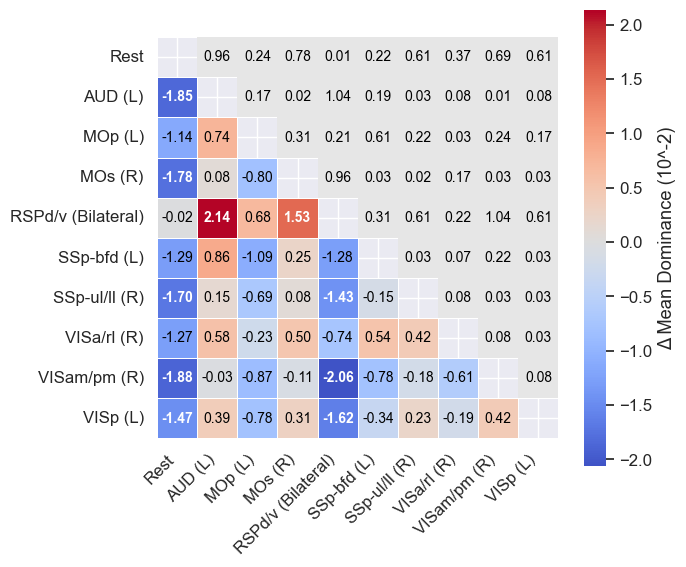


Statistical Results (Paired t-test vs Rest with FDR correction):
----------------------------------------------------------------------
Condition           N Pairs   Raw p          FDR p          Sig.
----------------------------------------------------------------------
AUD (L)             8         0.0098         0.1101         No
MOp (L)             7         0.1979         0.5760         No
MOs (R)             8         0.0183         0.1649         No
RSPd/v (Bilateral)  7         0.9684         0.9684         No
SSp-bfd (L)         7         0.2675         0.6020         No
SSp-ul/ll (R)       8         0.0405         0.2451         No
VISa/rl (R)         8         0.1132         0.4247         No
VISam/pm (R)        8         0.0274         0.2055         No
VISp (L)            8         0.0563         0.2451         No
----------------------------------------------------------------------


In [3]:
import pickle 

with open('domirank_results.pkl', 'rb') as f:
	domirank_results = pickle.load(f)

# 4. Visualize results
print("\n>>> Step 4: Visualizing results <<<")
plot_domirank_results(domirank_results, network_type='TE')

In [ ]:
def classify_key_nodes_extended(results, percentile=95):
    """
    Enhanced unified identification of key nodes across all conditions with 7 categories
    Returns:
        global_thresholds: Dictionary of global thresholds for all metrics
        key_nodes: Dictionary of key node classifications
        roi_classifications: Detailed classification records for each ROI across conditions
    """
    # Initialize data structures
    global_thresholds = {
        'degree': None,
        'betweenness': None,
        'dominance': None
    }
    
    key_nodes = {
        'global_hub': set(),
        'dominant_hub': set(),
        'connector_hub': set(),
        'structural_hub': set(),
        'dominant_node': set(),
        'degree_hub': set(),
        'connector_node': set()
    }
    
    roi_classifications = {}
    
    # Collect all data to compute global thresholds
    all_degrees = []
    all_betweenness = []
    all_dominance = []
    
    # Process Rest condition data
    for source, data in results['rest'].items():
        all_degrees.extend(data['degree_centrality'])
        all_betweenness.extend(data['betweenness'])
        all_dominance.extend(data['domirank'])
    
    # Process other conditions
    for cond in results['conditions']:
        source = list(results['conditions'][cond].keys())[0]
        data = results['conditions'][cond][source]
        all_degrees.extend(data['degree_centrality'])
        all_betweenness.extend(data['betweenness'])
        all_dominance.extend(data['domirank'])
    
    # Compute global thresholds
    global_thresholds['degree'] = np.percentile(all_degrees, percentile) if all_degrees else 0
    global_thresholds['betweenness'] = np.percentile(all_betweenness, percentile) if all_betweenness else 0
    global_thresholds['dominance'] = np.percentile(all_dominance, percentile) if all_dominance else 0
    
    # Get ROI names
    roi_names = results.get('roi_names', None)
    if roi_names is None:
        first_source = list(results['rest'].keys())[0]
        roi_names = results['rest'][first_source].get('roi_labels',
                     [f"ROI-{i}" for i in range(len(results['rest'][first_source]['domirank']))])
    
    # Initialize ROI classification records
    num_rois = len(roi_names)
    for i in range(num_rois):
        roi_classifications[i] = {
            'name': roi_names[i],
            'conditions': defaultdict(dict)  # Stores metrics and classification per condition
        }
    
    # Classify across all conditions
    conditions = ['Rest'] + list(results['conditions'].keys())
    for cond in conditions:
        # Get condition data
        if cond == 'Rest':
            source = list(results['rest'].keys())[0]
            data = results['rest'][source]
        else:
            source = list(results['conditions'][cond].keys())[0]
            data = results['conditions'][cond][source]
        
        degree = np.array(data['degree_centrality'])
        betweenness = np.array(data['betweenness'])
        dominance = np.array(data['domirank'])
        
        for i in range(len(degree)):
            # Check threshold crossings
            is_high_degree = degree[i] > global_thresholds['degree']
            is_high_betweenness = betweenness[i] > global_thresholds['betweenness']
            is_high_dominance = dominance[i] > global_thresholds['dominance']
            
            # Store raw metrics for this condition
            roi_classifications[i]['conditions'][cond].update({
                'degree': degree[i],
                'betweenness': betweenness[i],
                'dominance': dominance[i],
                'is_high_degree': is_high_degree,
                'is_high_betweenness': is_high_betweenness,
                'is_high_dominance': is_high_dominance
            })
            
            # Determine classification (priority order matters!)
            if is_high_dominance and is_high_degree and is_high_betweenness:
                classification = 'global_hub'
                key_nodes['global_hub'].add(i)
            elif is_high_dominance and is_high_degree:
                classification = 'dominant_hub'
                key_nodes['dominant_hub'].add(i)
            elif is_high_dominance and is_high_betweenness:
                classification = 'connector_hub'
                key_nodes['connector_hub'].add(i)
            elif is_high_degree and is_high_betweenness:
                classification = 'structural_hub'
                key_nodes['structural_hub'].add(i)
            elif is_high_dominance:
                classification = 'dominant_node'
                key_nodes['dominant_node'].add(i)
            elif is_high_degree:
                classification = 'degree_hub'
                key_nodes['degree_hub'].add(i)
            elif is_high_betweenness:
                classification = 'connector_node'
                key_nodes['connector_node'].add(i)
            else:
                classification = 'normal'
            
            # Record classification
            roi_classifications[i]['conditions'][cond]['classification'] = classification
    
    return global_thresholds, key_nodes, roi_classifications

In [5]:
# 5. Unified node classification
global_thresholds, key_nodes, roi_classifications = classify_key_nodes_extended(domirank_results, percentile=95)

In [ ]:
def plot_rank_distribution_comparison(results, roi_classifications):
    """
    Visualize DomiRank distributions across all conditions in a single line plot.
    Rest condition is shown in red, other conditions use viridis colors based on their order.
    """
    # Extract condition info (including Rest)
    conditions = ['Rest'] + list(results['conditions'].keys())
    
    # Get ROI names (sorted by ROI index)
    roi_names = []
    for i in sorted(roi_classifications.keys()):
        roi_names.append(roi_classifications[i]['name'])
    
    # Create figure
    plt.figure(figsize=(6, 4), dpi=300)
    viridis = plt.cm.viridis
    condition_colors = {cond: viridis(i/(len(conditions)-1)) for i, cond in enumerate(conditions[1:])}
    
    # Plot each condition's DomiRank distribution
    for cond in conditions:
        # Get data for this condition
        if cond == 'Rest':
            source = list(results['rest'].keys())[0]
            data = results['rest'][source]
            color = 'red'
            linewidth = 2.5
            alpha = 0.9
            label = 'Rest'
        else:
            source = list(results['conditions'][cond].keys())[0]
            data = results['conditions'][cond][source]
            color = condition_colors[cond]
            linewidth = 1.5
            alpha = 0.7
            label = cond
        
        domirank = np.array(data['domirank'])
        
        # Sort data (descending)
        sorted_domi = np.sort(domirank)[::-1]
        
        # Plot line (log scale)
        plt.plot(range(len(sorted_domi)), sorted_domi, 
                 color=color, 
                 linewidth=linewidth,
                 alpha=alpha,
                 label=label)
    
    plt.yscale('log')
    plt.xlabel('ROI Rank', fontsize=12)
    plt.ylabel('DomiRank Score (log)', fontsize=12)
    # plt.title('DomiRank Distribution Across Conditions', fontsize=14, pad=20)
    plt.grid(True, which='both', linestyle='--', alpha=0.4)
    # plt.legend(fontsize=10, framealpha=0.9, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('domirank_distribution_comparison.pdf', bbox_inches='tight')
    plt.show()

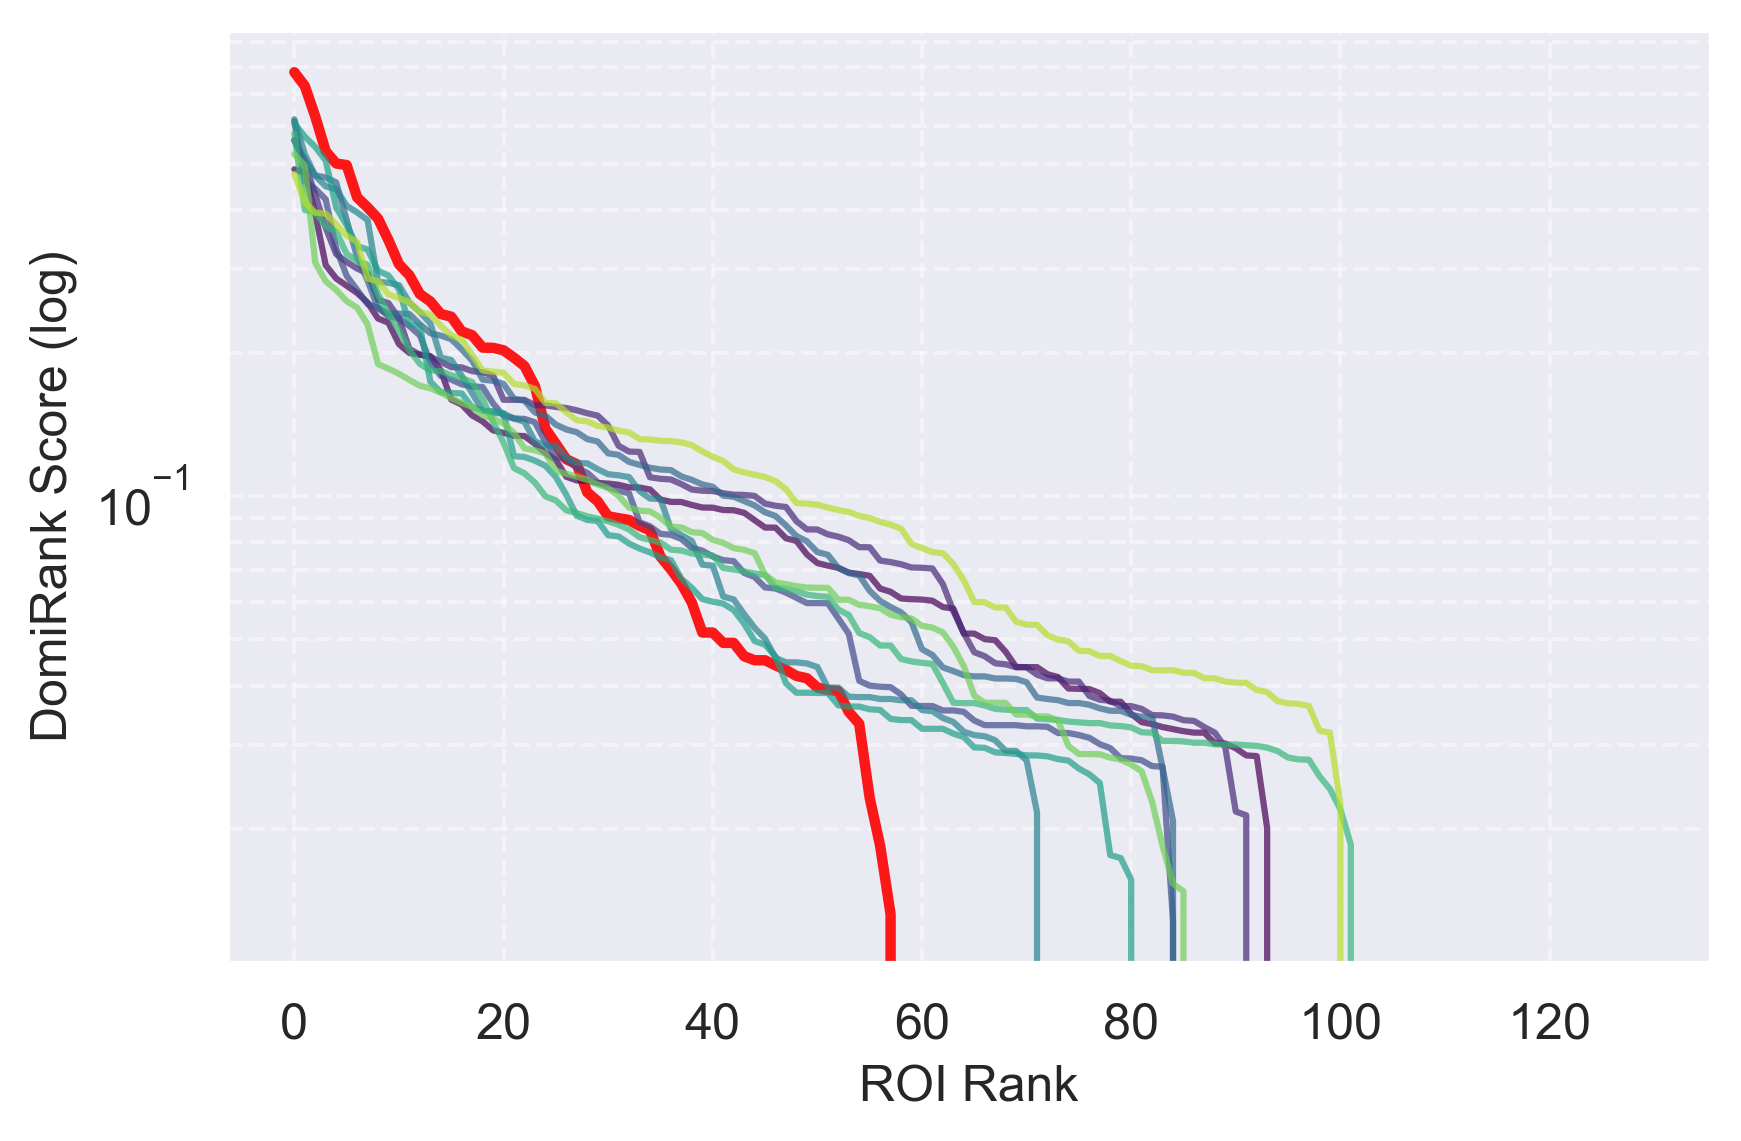

In [7]:
plot_rank_distribution_comparison(domirank_results, roi_classifications)

In [ ]:
def plot_combined_results(results, global_thresholds, key_nodes, roi_classifications):
    """
    Three-in-one visualization (includes Rest condition)
    Split into multiple figures with 5 conditions per figure
    """
    # Extract condition info (including Rest)
    conditions = ['Rest'] + list(results['conditions'].keys())
    num_conditions = len(conditions)
    
    # Get ROI names
    roi_names = []
    for i in sorted(roi_classifications.keys()):
        roi_names.append(roi_classifications[i]['name'])
    
    # Global settings
    plt.rcParams.update({'font.size': 10})
    top_n_nodes = 10  # Number of top nodes to display
    
    # Node type style definitions (using the new color scheme)
    node_styles = {
        'global_hub': {'color': '#0c3547', 'label': 'Global Hub', 'marker': 'D', 'size': 80},
        'dominant_hub': {'color': '#10656d', 'label': 'Dominant Hub', 'marker': 's', 'size': 70},
        'connector_hub': {'color': '#598f91', 'label': 'Connector Hub', 'marker': '^', 'size': 70},
        'structural_hub': {'color': '#93b071', 'label': 'Structural Hub', 'marker': 'v', 'size': 70},
        'dominant_node': {'color': '#f0d59e', 'label': 'Dominant Node', 'marker': 'o', 'size': 60},
        'degree_hub': {'color': '#edae93', 'label': 'Degree Hub', 'marker': 'p', 'size': 60},
        'connector_node': {'color': '#dd6670', 'label': 'Connector Node', 'marker': 'h', 'size': 60},
        'normal': {'color': 'gray', 'label': 'Normal', 'marker': '.', 'size': 30}
    }

    # Split conditions into two groups
    figure_count = 0
    group1 = conditions[:5]
    group2 = conditions[5:]

    for group_idx, current_conditions in enumerate([group1, group2]):
        if not current_conditions:
            continue
            
        figure_count += 1
        num_current_conditions = len(current_conditions)
        
        # Create figure for this group
        fig, axes = plt.subplots(num_current_conditions, 3, 
                                figsize=(14, 4*num_current_conditions), 
                                dpi=300)
        
        if num_current_conditions == 1:
            axes = axes.reshape(1, -1)
        
        for i, cond in enumerate(current_conditions):
            # Get data for this condition
            if cond == 'Rest':
                source = list(results['rest'].keys())[0]
                data = results['rest'][source]
            else:
                source = list(results['conditions'][cond].keys())[0]
                data = results['conditions'][cond][source]
            
            domirank = np.array(data['domirank'])
            degree = np.array(data['degree_centrality'])
            betweenness = np.array(data['betweenness'])
            
            # ===== Left column: DomiRank distribution =====
            ax_left = axes[i, 0]
            
            # Sort data (descending)
            sorted_idx = np.argsort(domirank)[::-1]
            sorted_domi = domirank[sorted_idx]
            
            # Draw bar chart (log scale)
            colors = ['royalblue' if x < top_n_nodes else 'lightgray' for x in range(len(domirank))]
            bars = ax_left.bar(range(len(domirank)), sorted_domi, color=colors)
            ax_left.set_yscale('log')
            ax_left.set_title(f'DomiRank Distribution\n{cond}', pad=15)
            ax_left.set_xlabel('ROI Rank', labelpad=10)
            ax_left.set_ylabel('Score (log)', labelpad=10)
            ax_left.grid(axis='y', linestyle='--', alpha=0.6)
            
            # Add statistical lines (ignore zeros)
            non_zero = domirank[domirank > 0]
            median = np.median(non_zero) if len(non_zero) > 0 else 0
            ax_left.axhline(median, color='red', linestyle='--', label=f'Median: {median:.1e}')
            
            # ===== Middle column: Top nodes =====
            ax_mid = axes[i, 1]
            
            # Get top node indices and labels
            top_idx = np.argsort(-domirank)[:top_n_nodes]
            top_domi = domirank[top_idx]
            top_labels = [roi_names[i] for i in top_idx]
            
            # Horizontal bar chart (using colormap)
            colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n_nodes))
            ax_mid.barh(top_labels, top_domi, color=colors)
            ax_mid.set_title(f'Top {top_n_nodes} Nodes\n{cond}', pad=15)
            ax_mid.set_xlabel('DomiRank Score', labelpad=10)
            ax_mid.grid(axis='x', linestyle='--', alpha=0.6)
            
            # ===== Right column: Correlation analysis (using unified classification) =====
            ax_right = axes[i, 2]
            
            # Calculate correlation coefficients
            r_degree = pearsonr(degree, domirank)[0] if len(degree) > 1 else np.nan
            r_betweenness = pearsonr(betweenness, domirank)[0] if len(betweenness) > 1 else np.nan
            
            # Draw background scatter plot (gray points for normal nodes)
            ax_right.scatter(degree, domirank, marker='.', color='lightgray', alpha=0.2, s=20, label='Degree (all)')
            ax_right.scatter(betweenness, domirank, marker='.', color='lightgray', alpha=0.2, s=20, label='Betweenness (all)')
            
            # Use unified classification to annotate key nodes
            texts = []
            for j in range(len(domirank)):
                classification = roi_classifications[j]['conditions'].get(cond, {}).get('classification', 'normal')
                
                if classification != 'normal':
                    style = node_styles[classification]
                    
                    # Plot based on the most relevant centrality measure
                    if classification in ['global_hub', 'dominant_hub', 'degree_hub', 'dominant_node']:
                        # These types are more related to degree centrality
                        ax_right.scatter(degree[j], domirank[j],
                                        color=style['color'],
                                        marker=style['marker'],
                                        s=style['size'],
                                        alpha=0.8,
                                        edgecolor='white' if classification in ['global_hub', 'dominant_hub'] else None,
                                        linewidth=1 if classification in ['global_hub', 'dominant_hub'] else 0.5)
                        
                        # Add label for important nodes
                        if classification in ['global_hub', 'dominant_hub']:
                            texts.append(ax_right.text(
                                degree[j], domirank[j], roi_names[j],
                                fontsize=9, color='white', weight='bold',
                                bbox=dict(boxstyle='round,pad=0.3', 
                                        fc=style['color'],
                                        ec='white', alpha=0.9)))
                    
                    elif classification in ['connector_hub', 'structural_hub', 'connector_node']:
                        # These types are more related to betweenness centrality
                        ax_right.scatter(betweenness[j], domirank[j],
                                        color=style['color'],
                                        marker=style['marker'],
                                        s=style['size'],
                                        alpha=0.8,
                                        edgecolor='white' if classification in ['connector_hub', 'structural_hub'] else None,
                                        linewidth=1 if classification in ['connector_hub', 'structural_hub'] else 0.5)
                        
                        # Add label for important nodes
                        if classification in ['connector_hub', 'structural_hub']:
                            texts.append(ax_right.text(
                                betweenness[j], domirank[j], roi_names[j],
                                fontsize=9, color='white', weight='bold',
                                bbox=dict(boxstyle='round,pad=0.3', 
                                        fc=style['color'],
                                        ec='white', alpha=0.9)))
            
            # Adjust label positions
            if texts:
                adjust_text(texts,
                           ax=ax_right,
                           expand_points=(15, 15),
                           expand_text=(10,10),
                           force_points=(1, 1),
                           arrowprops=dict(arrowstyle='->', color='gray', lw=0.7),
                           precision=0.01)
            
            # Create professional legend
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], linestyle='none', 
                       label=f'Degree r={r_degree:.2f}' if not np.isnan(r_degree) else 'Degree r=N/A', 
                       marker='o', markersize=8, alpha=0.6),
                Line2D([0], [0], linestyle='none', 
                       label=f'Betweenness r={r_betweenness:.2f}' if not np.isnan(r_betweenness) else 'Betweenness r=N/A', 
                       marker='s', markersize=8, alpha=0.6),
                Line2D([0], [0], linestyle='none',
                       label='All Nodes',
                       marker='.',
                       markerfacecolor='lightgray', alpha=0.4),
            ]
            
            # Add node type legend items
            for node_type in ['global_hub', 'dominant_hub', 'connector_hub', 
                             'structural_hub', 'dominant_node', 'degree_hub', 
                             'connector_node']:
                style = node_styles[node_type]
                legend_elements.append(
                    Line2D([0], [0], linestyle='none',
                           label=style['label'],
                           marker=style['marker'],
                           markerfacecolor=style['color'],
                           markersize=10,
                           markeredgecolor='white' if node_type in ['global_hub', 'dominant_hub', 'connector_hub', 'structural_hub'] else None,
                           markeredgewidth=1 if node_type in ['global_hub', 'dominant_hub', 'connector_hub', 'structural_hub'] else 0.5)
                )

            # ax_right.legend(handles=legend_elements, loc='lower right', 
                        #    fontsize=8, framealpha=0.9, ncol=2)

            ax_right.set_title(f'DomiRank vs Centrality\n{cond}', pad=15)
            ax_right.set_xlabel('Centrality Score', labelpad=10)
            ax_right.set_ylabel('DomiRank Score', labelpad=10)
            ax_right.grid(True, linestyle='--', alpha=0.6)
        
        plt.subplots_adjust(hspace=0.5, wspace=0.4)
        plt.tight_layout()
        
        plt.savefig(f'combined_results_part{figure_count}.pdf', bbox_inches='tight')
        plt.show()

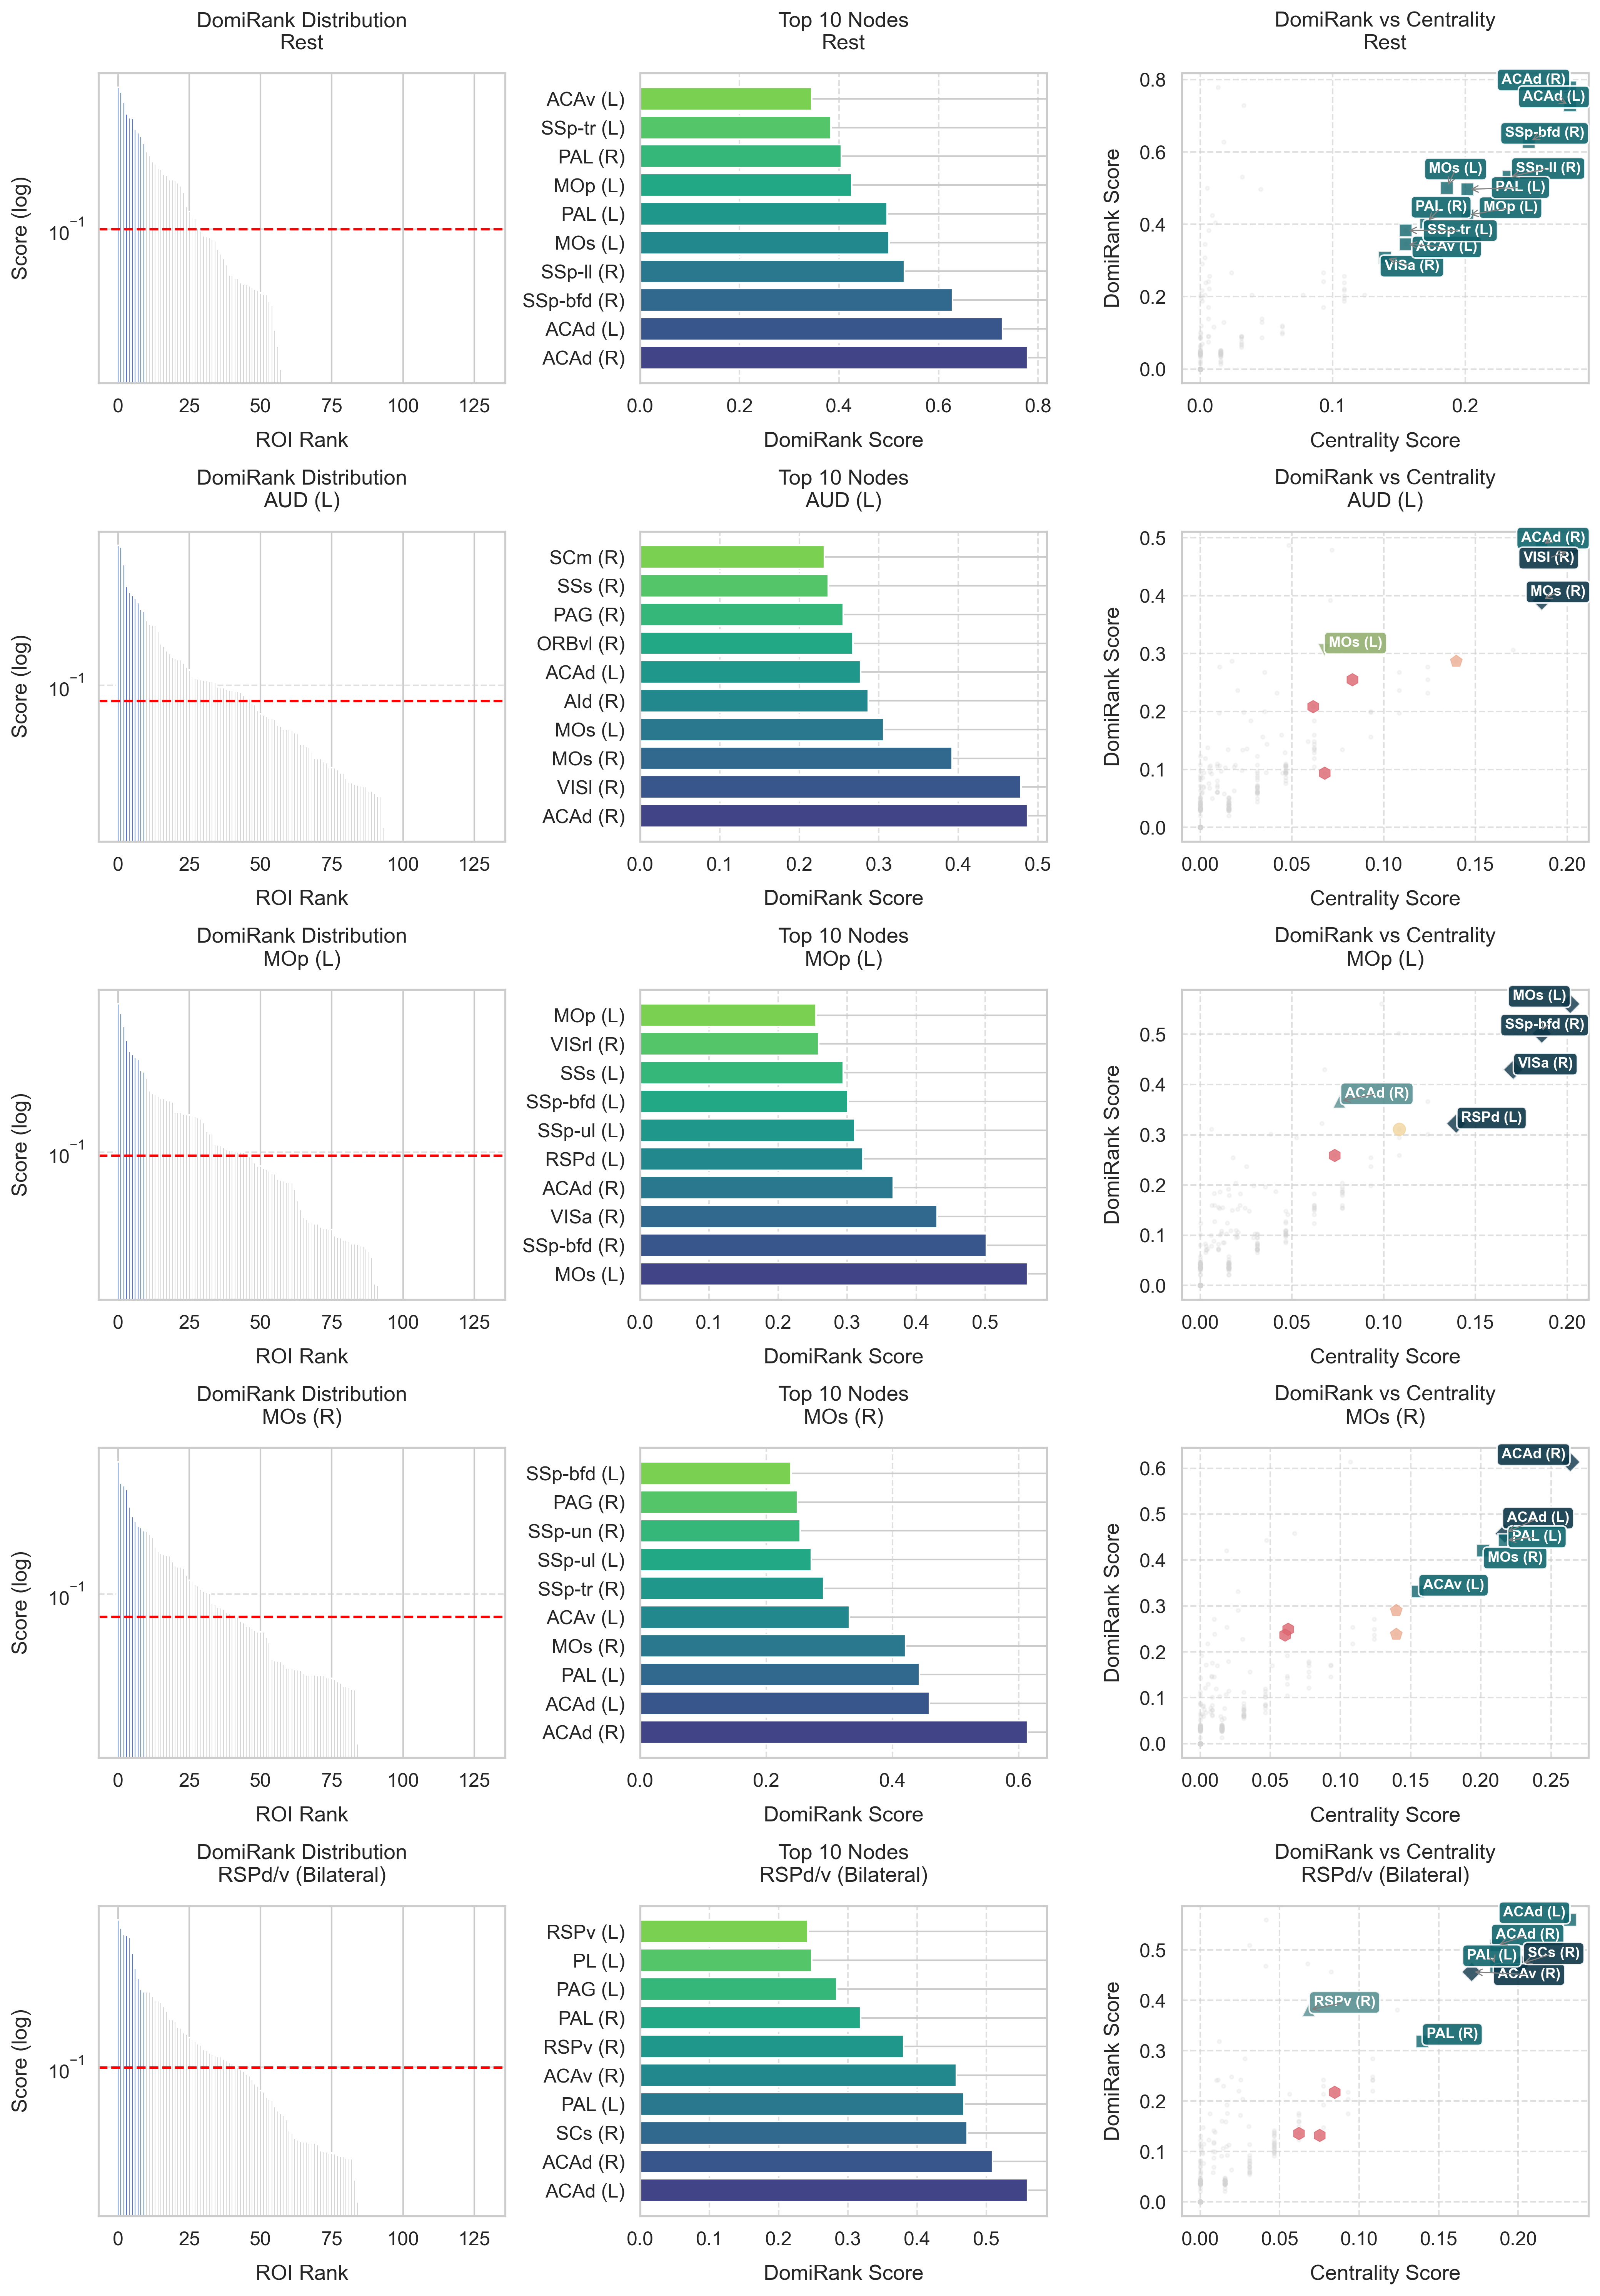

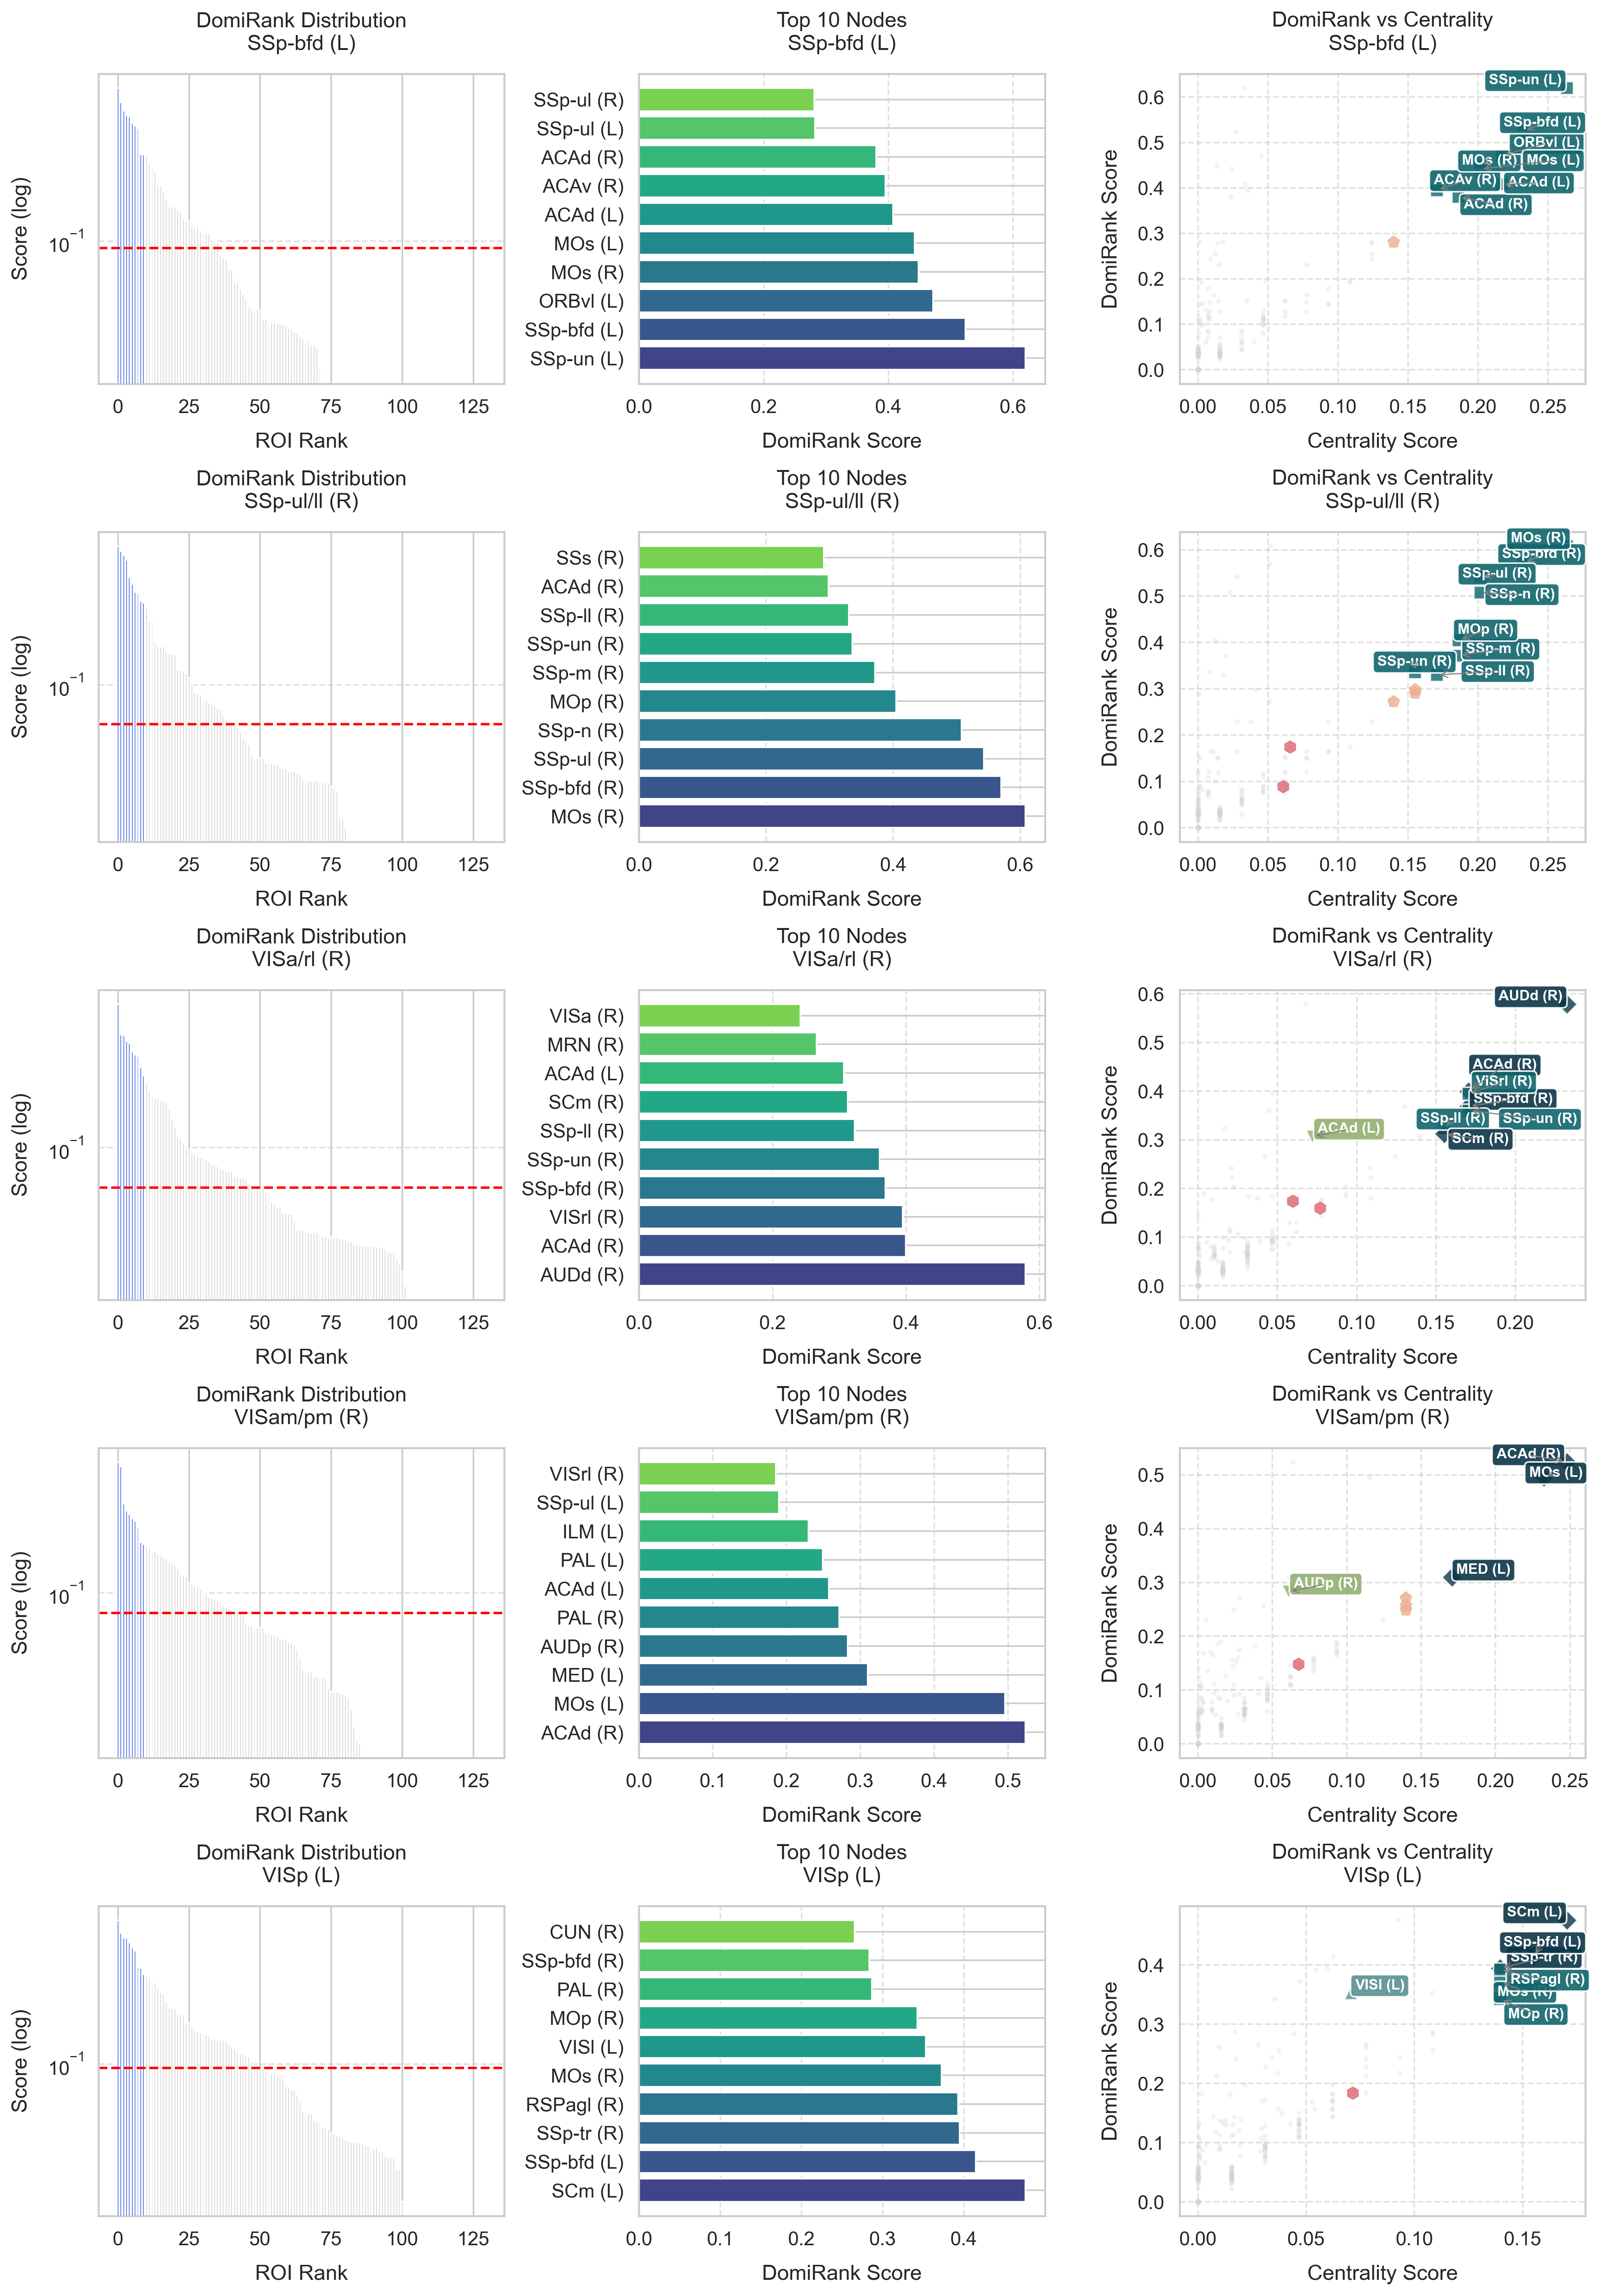

In [33]:
plot_combined_results(domirank_results, global_thresholds, key_nodes, roi_classifications)

In [ ]:
def plot_cross_condition_comparison(results, key_nodes, roi_classifications):
    """
    Plot cross-condition comparison of specially marked nodes with performance visualization
    Includes stacked bar chart showing distribution of key node types across conditions
    
    Returns:
        roi_classifications: Dictionary of ROI classification info
        key_nodes_by_type: Dictionary of key nodes grouped by type
    """
    # Define visual styles for different node types
    node_type_colors = {
        'global_hub': '#0c3547',
        'dominant_hub': '#10656d',
        'connector_hub': '#598f91',
        'structural_hub': '#93b071',
        'dominant_node': '#f0d59e',
        'degree_hub': '#edae93',
        'connector_node': '#dd6670',
        'normal': 'gray'
    }
    
    node_type_markers = {
        'global_hub': 'D',
        'dominant_hub': 's',
        'connector_hub': '^',
        'structural_hub': 'v',
        'dominant_node': 'o',
        'degree_hub': 'p',
        'connector_node': 'h',
        'normal': '.'
    }
    
    # Extract ROI names from classifications
    roi_names = []
    for i in sorted(roi_classifications.keys()):
        roi_names.append(roi_classifications[i]['name'])
    
    # Get all conditions including Rest
    conditions = ['Rest'] + list(results['conditions'].keys())
    num_rois = len(roi_names)
    
    # Initialize dictionary to store nodes by type
    key_nodes_by_type = {
        'global_hub': [],
        'dominant_hub': [],
        'connector_hub': [],
        'structural_hub': [],
        'dominant_node': [],
        'degree_hub': [],
        'connector_node': []
    }
    
    # Create main figure for DomiRank changes
    fig_main = plt.figure(figsize=(18, 12), dpi=300)
    ax_main = fig_main.add_subplot(111)
    
    # Prepare data for plotting
    node_data = []
    node_types = []
    node_labels = []
    
    # Collect all key nodes (excluding normal nodes)
    all_key_nodes = []
    for node_type in ['global_hub', 'dominant_hub', 'connector_hub', 
                     'structural_hub', 'dominant_node', 'degree_hub', 
                     'connector_node']:
        all_key_nodes.extend(list(key_nodes[node_type]))
        key_nodes_by_type[node_type] = list(key_nodes[node_type])
    
    # Process each key node
    for node_idx in all_key_nodes:
        # Determine most significant classification across conditions
        classifications = []
        for cond in conditions:
            classification = roi_classifications[node_idx]['conditions'].get(cond, {}).get('classification', 'normal')
            classifications.append(classification)
        
        priority_order = ['global_hub', 'dominant_hub', 'connector_hub',
                         'structural_hub', 'dominant_node', 'degree_hub',
                         'connector_node']
        
        node_type = 'normal'
        for cat in priority_order:
            if cat in classifications:
                node_type = cat
                break
        
        # Collect DomiRank scores across conditions
        domiranks = []
        for cond in conditions:
            if cond == 'Rest':
                source = list(results['rest'].keys())[0]
                data = results['rest'][source]
            else:
                source = list(results['conditions'][cond].keys())[0]
                data = results['conditions'][cond][source]
            
            domiranks.append(data['domirank'][node_idx])
        
        node_data.append(domiranks)
        node_types.append((node_type_colors[node_type], node_type_markers[node_type]))
        node_labels.append(roi_names[node_idx])
    
    # Plot lines and markers for each node
    x = range(len(conditions))
    for i, (data, (color, marker)) in enumerate(zip(node_data, node_types)):
        ax_main.plot(x, data, color=color, alpha=0.3, lw=1)
        for j, y in enumerate(data):
            ax_main.scatter(j, y, color=color, marker=marker, s=80, alpha=0.7)
    
    # Add labels with text adjustment to avoid overlap
    texts = []
    for j, cond in enumerate(conditions):
        for i, (data, (color, _)) in enumerate(zip(node_data, node_types)):
            texts.append(ax_main.text(j, data[j], node_labels[i], 
                                     fontsize=8, color=color,
                                     ha='center', va='bottom'))
    
    adjust_text(texts, ax=ax_main, 
               expand_points=(1.2, 1.2), 
               expand_text=(1.1, 1.1),
               arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
    
    ax_main.set_ylabel('DomiRank Score', labelpad=10)
    ax_main.set_xticks(x)
    ax_main.set_xticklabels(conditions, rotation=45, ha='right')
    ax_main.grid(True, linestyle='--', alpha=0.6)
    
    # Save main plot
    fig_main.savefig('cross_condition_comparison_main.pdf', bbox_inches='tight')
    plt.close(fig_main)
    
    # Create node type distribution plot
    fig_types = plt.figure(figsize=(6, 3), dpi=300)
    ax_types = fig_types.add_subplot(111)
    
    type_counts = [
        len(key_nodes['global_hub']),
        len(key_nodes['dominant_hub']),
        len(key_nodes['connector_hub']),
        len(key_nodes['structural_hub']),
        len(key_nodes['dominant_node']),
        len(key_nodes['degree_hub']),
        len(key_nodes['connector_node'])
    ]
    
    type_labels = [
        'Global Hubs', 
        'Dominant Hubs', 
        'Connector Hubs',
        'Structural Hubs',
        'Dominant Nodes',
        'Degree Hubs',
        'Connector Nodes'
    ]
    
    type_colors = [
        node_type_colors['global_hub'],
        node_type_colors['dominant_hub'],
        node_type_colors['connector_hub'],
        node_type_colors['structural_hub'],
        node_type_colors['dominant_node'],
        node_type_colors['degree_hub'],
        node_type_colors['connector_node']
    ]
    
    ax_types.bar(type_labels, type_counts, color=type_colors)
    ax_types.set_ylabel('Count', labelpad=10)
    
    # Add value labels on bars
    for i, v in enumerate(type_counts):
        ax_types.text(i, v + 0.5, str(v), ha='center')
    
    plt.xticks(rotation=45, ha='right')
    fig_types.savefig('node_type_distribution.pdf', bbox_inches='tight')
    plt.show(fig_types)
    
    # Create stacked bar chart showing node type distribution across conditions
    fig_stack = plt.figure(figsize=(6, 10), dpi=300)
    ax_stack = fig_stack.add_subplot(111)

    # Initialize data structure for stacked bars
    stack_data = {
        'global_hub': np.zeros(num_rois),
        'dominant_hub': np.zeros(num_rois),
        'connector_hub': np.zeros(num_rois),
        'structural_hub': np.zeros(num_rois),
        'dominant_node': np.zeros(num_rois),
        'degree_hub': np.zeros(num_rois),
        'connector_node': np.zeros(num_rois)
    }

    # Count type occurrences for each ROI
    for roi_idx in range(num_rois):
        for cond in conditions:
            classification = roi_classifications[roi_idx]['conditions'].get(cond, {}).get('classification', 'normal')
            if classification in stack_data:
                stack_data[classification][roi_idx] += 1

    # Filter ROIs that are key nodes in at least one condition
    relevant_rois = [roi_idx for roi_idx in range(num_rois) 
                    if np.sum([stack_data[t][roi_idx] for t in stack_data]) > 0]

    if not relevant_rois:
        ax_stack.text(0.5, 0.5, 'No key nodes found across conditions', 
                    ha='center', va='center', fontsize=12)
    else:
        # Sort ROIs by significance
        def sort_key(roi_idx):
            scores = []
            for t in ['global_hub', 'dominant_hub', 'connector_hub',
                     'structural_hub', 'dominant_node', 'degree_hub',
                     'connector_node']:
                scores.append(stack_data[t][roi_idx])
            return tuple(-s for s in scores)
        
        relevant_rois_sorted = sorted(relevant_rois, key=sort_key)[::-1]
        
        # Prepare plotting parameters
        left = np.zeros(len(relevant_rois_sorted))
        colors = [node_type_colors[t] for t in stack_data.keys()]
        labels = [t.replace('_', ' ').title() for t in stack_data.keys()]
        
        # Draw horizontal stacked bars
        for i, (key, color) in enumerate(zip(stack_data.keys(), colors)):
            counts = stack_data[key][relevant_rois_sorted]
            ax_stack.barh(range(len(relevant_rois_sorted)), counts, left=left, 
                        color=color, label=labels[i], alpha=0.8)
            left += counts
        
        # Set y-axis labels
        ax_stack.set_yticks(range(len(relevant_rois_sorted)))
        ax_stack.set_yticklabels([roi_names[i] for i in relevant_rois_sorted], 
                            fontsize=8)
        
        # Add total counts on right side
        for roi_pos, roi_idx in enumerate(relevant_rois_sorted):
            total = sum(stack_data[t][roi_idx] for t in stack_data)
            ax_stack.text(total + 0.1, roi_pos, str(int(total)), 
                        ha='left', va='center', fontsize=8)
    
    ax_stack.set_xlabel('Count', fontsize=12)
    fig_stack.savefig('key_node_distribution.pdf', bbox_inches='tight')
    plt.show(fig_stack)
    
    return roi_classifications, key_nodes_by_type

4 [0.29643742 0.00067522]
7 [0.53311451 0.37097866]
14 [-0.73108165  0.04961381]
33 [-0.83973865 -0.34790569]
36 [-0.76396828 -0.03924372]
40 [-0.38082972 -0.48168934]
41 [-0.22635107  0.97846397]
57 [0.22809738 0.1854389 ]
59 [ 0.49485158 -0.58402171]
61 [-0.40905666 -0.35180021]
62 [-0.58365392  0.92680588]
63 [0.31207489 0.65048299]
64 [-0.11833851  0.82470604]
65 [-0.38543295 -0.0201749 ]
67 [-0.27882424 -0.77187073]
27 [-0.29260104 -0.69262073]
55 [0.43063448 0.42578518]
3 [-0.62123285  0.64787916]
18 [0.43792094 0.06338946]
56 [0.43778995 0.96443289]
9 [ 0.45949657 -0.212466  ]
52 [ 0.11172049 -0.06770501]
25 [-0.73143805 -0.20240554]
66 [-0.40925073  0.70420736]
10 [ 0.08960856 -0.23528579]
34 [-0.18086196  0.61733064]
53 [0.58933006 0.72618519]
21 [ 0.46106261 -0.58512259]
54 [0.44252737 0.98965823]
30 [ 0.62598134 -0.18853497]
46 [0.59783816 0.83646107]
17 [ 0.65780209 -0.34304174]
49 [0.58817821 0.62255209]
38 [-0.63676485 -0.93106065]
43 [-0.18831179  0.47165336]
8 [ 0.71209

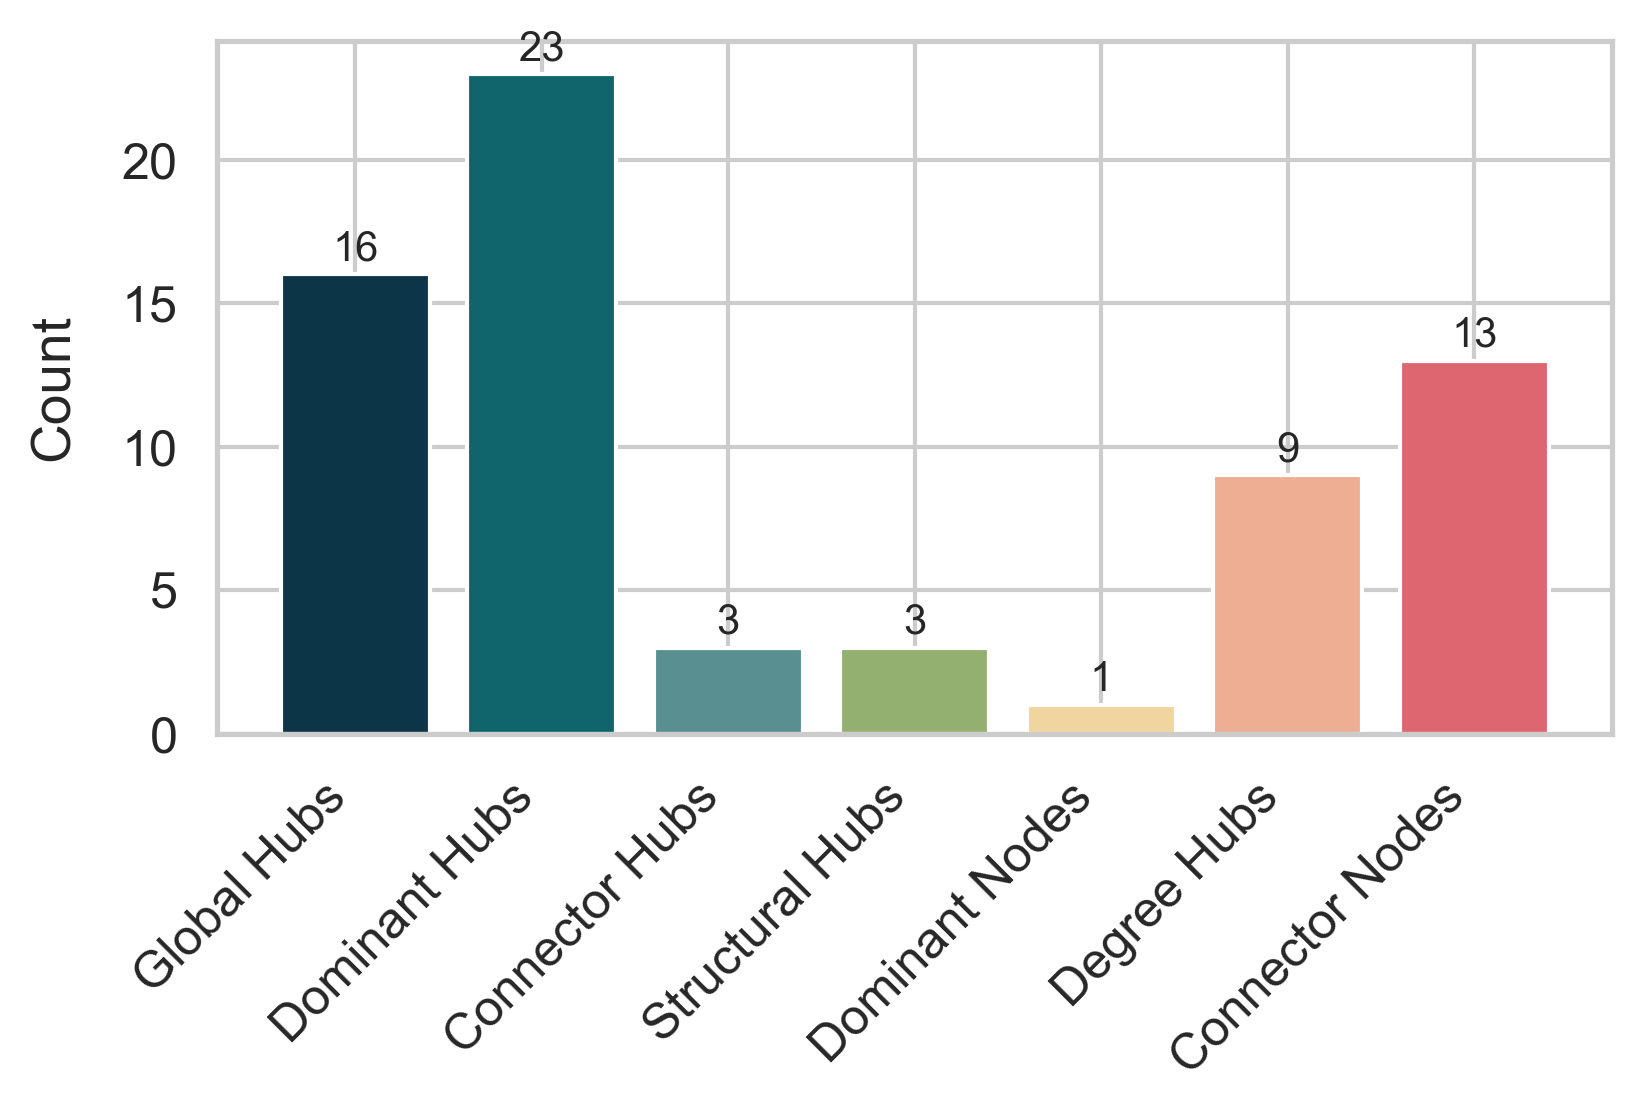

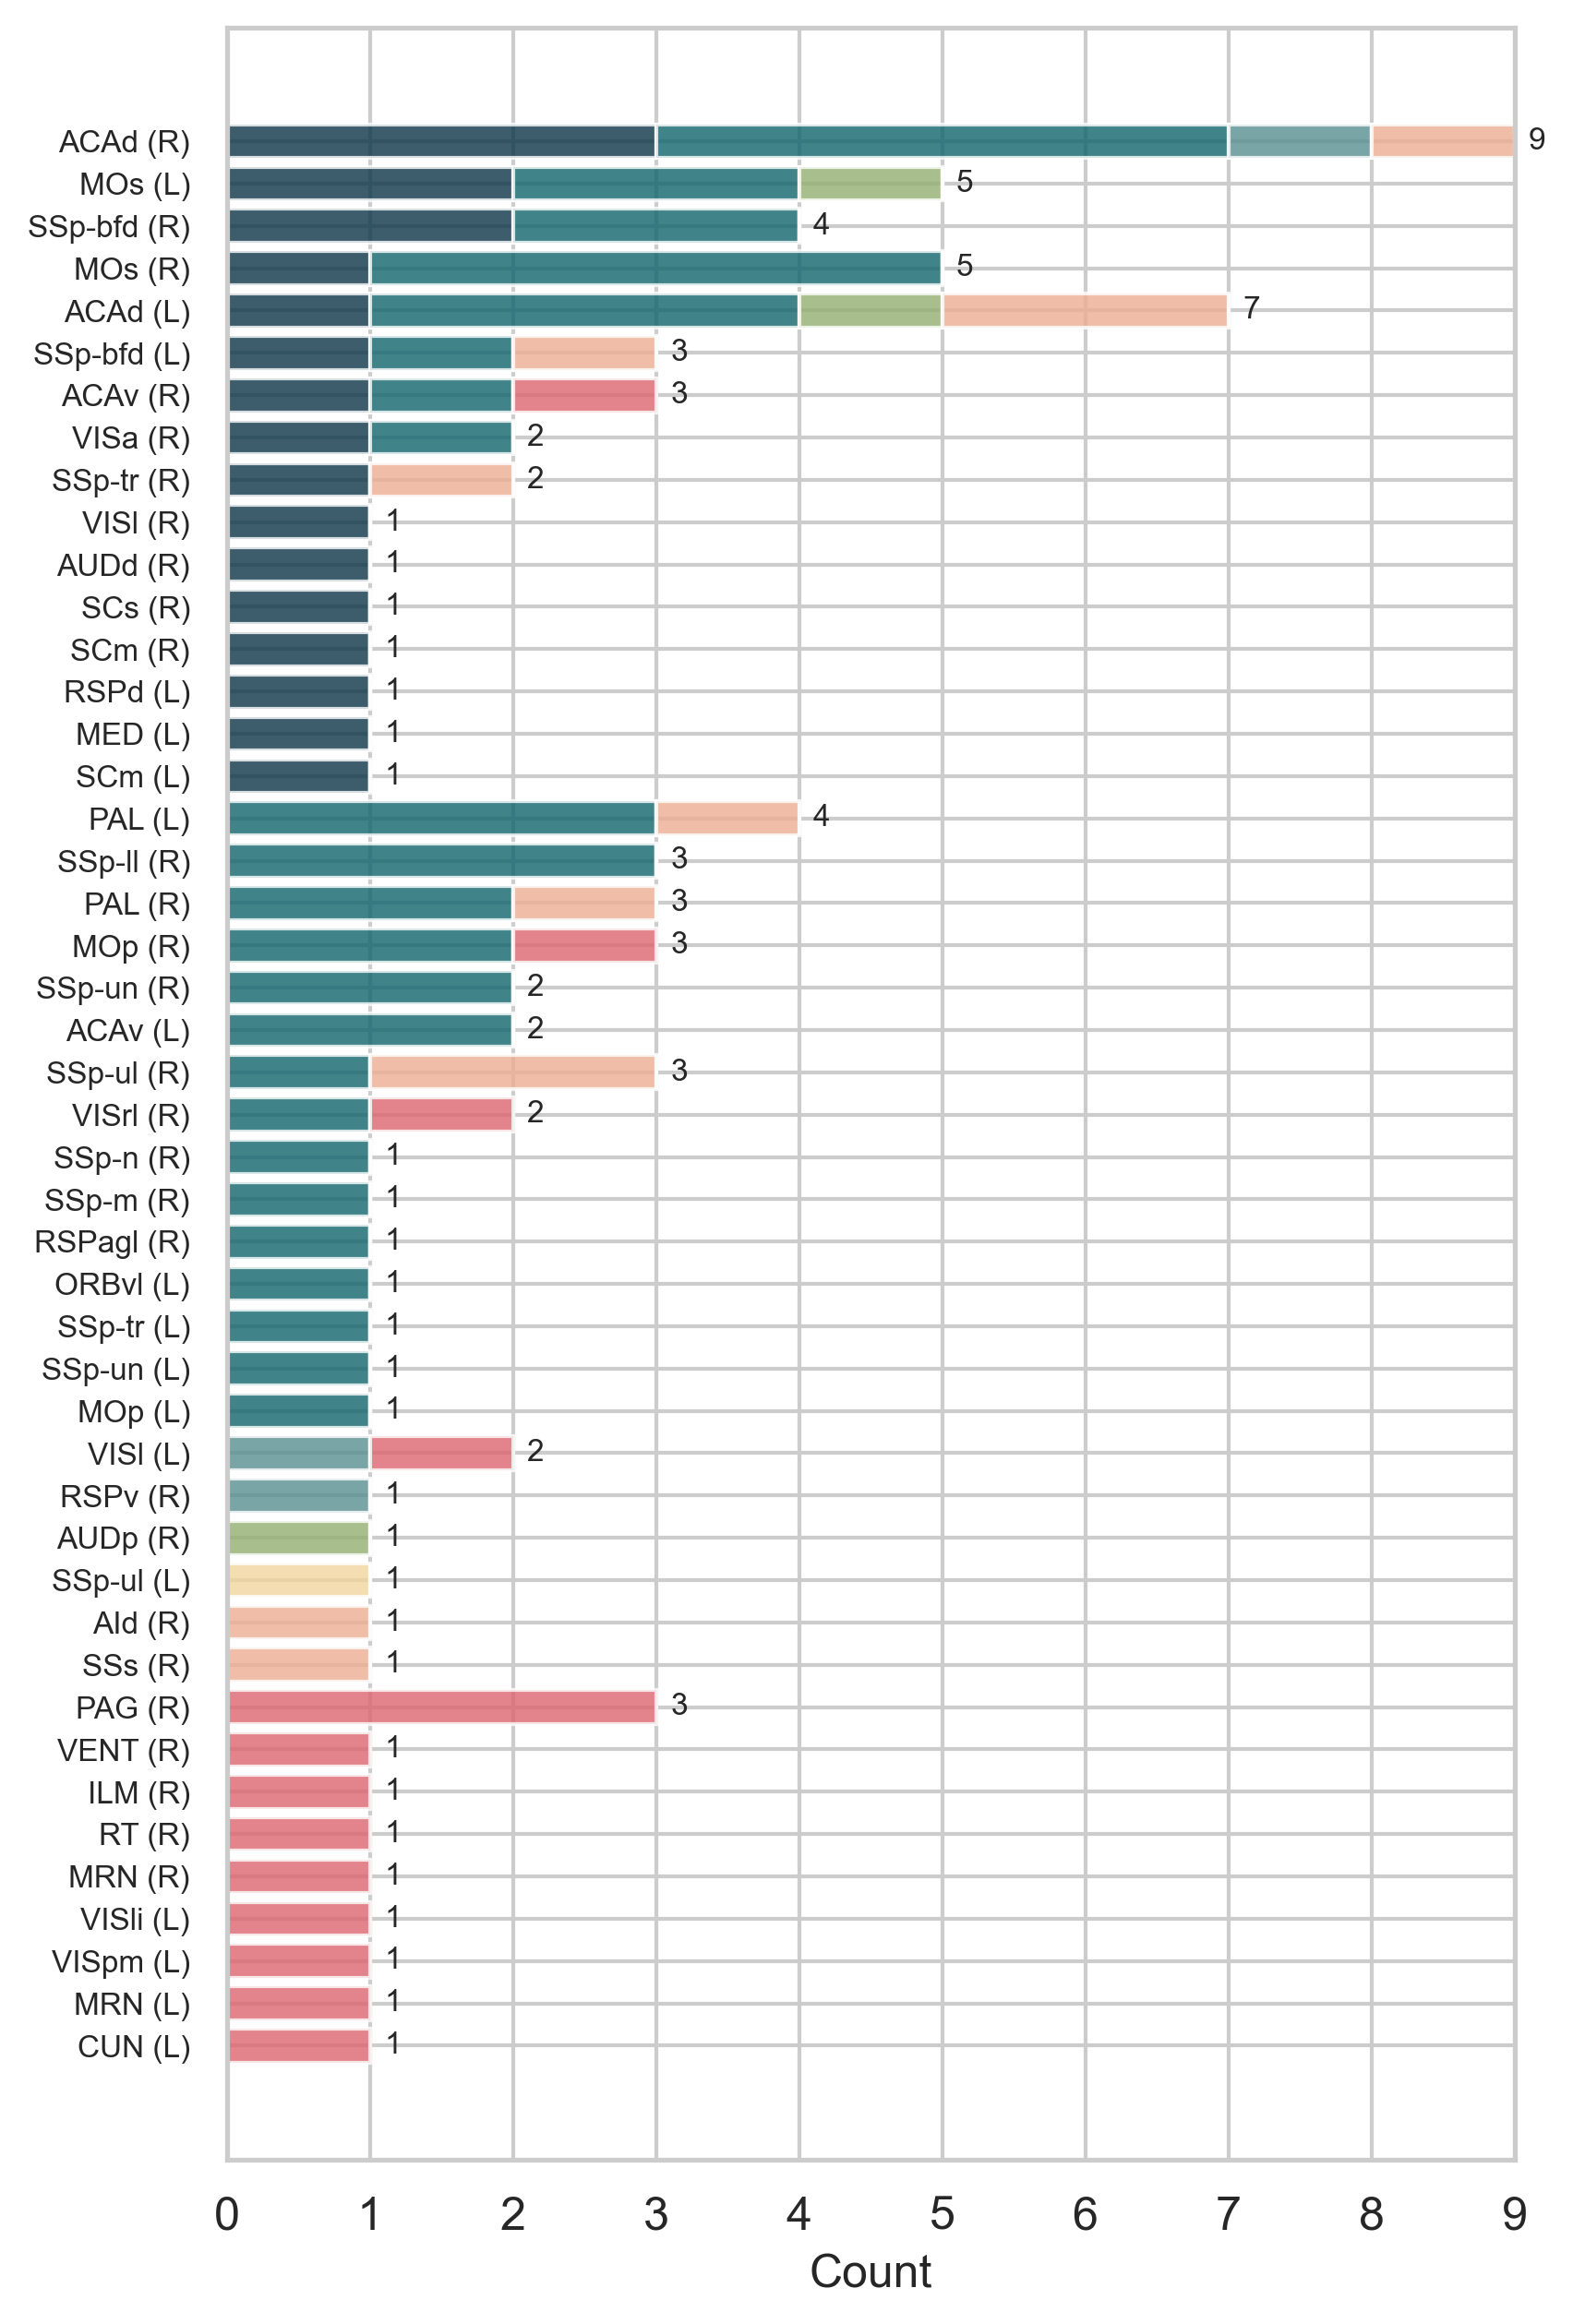

In [23]:
roi_classifications, key_nodes_by_type = plot_cross_condition_comparison(domirank_results, key_nodes, roi_classifications)

In [ ]:
def plot_combined_heatmap_and_stackbar(results, key_nodes, roi_classifications):
    """
    Creates separate visualizations for condition correlations and key node distributions
    
    Returns:
        None (saves plots as PDF files)
    """
    # Get all conditions including Rest
    conditions = ['Rest'] + list(results['conditions'].keys())
    
    # ===== Correlation Heatmap =====
    fig_heatmap = plt.figure(figsize=(6, 5), dpi=300)
    ax_heatmap = fig_heatmap.add_subplot(111)
    ax_heatmap.grid(False)
    
    # Compute DomiRank correlations between conditions
    domirank_matrix = []
    for cond in conditions:
        if cond == 'Rest':
            source = list(results['rest'].keys())[0]
            data = results['rest'][source]
        else:
            source = list(results['conditions'][cond].keys())[0]
            data = results['conditions'][cond][source]
        
        domirank_matrix.append(data['domirank'])
    
    corr_matrix = np.corrcoef(domirank_matrix)
    
    # Plot correlation heatmap
    im = ax_heatmap.imshow(corr_matrix, cmap='coolwarm', vmin=0, vmax=1)
    ax_heatmap.set_xticks(range(len(conditions)))
    ax_heatmap.set_yticks(range(len(conditions)))
    ax_heatmap.set_xticklabels(conditions, rotation=45, ha='right', fontsize=12)
    ax_heatmap.set_yticklabels(conditions, fontsize=12)
    
    # Add colorbar and correlation values
    cbar = fig_heatmap.colorbar(im, ax=ax_heatmap, shrink=0.7)
    cbar.set_label('Pearson Correlation', fontsize=12)
    
    for i in range(len(conditions)):
        for j in range(len(conditions)):
            ax_heatmap.text(j, i, f'{corr_matrix[i,j]:.2f}', 
                           ha='center', va='center', color='white', fontsize=10)
    
    fig_heatmap.savefig('inter_condition_correlation_heatmap.pdf', bbox_inches='tight')
    plt.show(fig_heatmap)
    
    # ===== Stacked Bar Chart =====
    fig_stackbar = plt.figure(figsize=(4, 5), dpi=300)
    ax_stackbar = fig_stackbar.add_subplot(111)

    # Define node type colors and labels
    node_type_colors = {
        'global_hub': '#0c3547',
        'dominant_hub': '#10656d',
        'connector_hub': '#598f91',
        'structural_hub': '#93b071',
        'dominant_node': '#f0d59e',
        'degree_hub': '#edae93',
        'connector_node': '#dd6670'
    }

    # Initialize data structure for counts
    stack_data = {key: [] for key in node_type_colors.keys()}

    # Count node types per condition
    for cond in conditions:
        counts = {key: 0 for key in node_type_colors.keys()}
        
        for roi_id, roi_data in roi_classifications.items():
            node_type = roi_data['conditions'].get(cond, {}).get('classification', 'normal')
            if node_type in node_type_colors:
                counts[node_type] += 1
        
        for key in stack_data:
            stack_data[key].append(counts[key])

    # Define plotting order and labels
    categories = [
        'global_hub',
        'dominant_hub',
        'connector_hub',
        'structural_hub',
        'dominant_node',
        'degree_hub',
        'connector_node'
    ]
    
    labels = [
        'Global Hubs',
        'Dominant Hubs',
        'Connector Hubs',
        'Structural Hubs',
        'Dominant Nodes',
        'Degree Hubs',
        'Connector Nodes'
    ]
    
    colors = [node_type_colors[cat] for cat in categories]

    # Plot horizontal stacked bars (top-to-bottom)
    left = np.zeros(len(conditions))
    positions = list(range(len(conditions)))[::-1]  # Reverse positions for top-down ordering

    for i, (key, color) in enumerate(zip(categories, colors)):
        counts = stack_data[key]
        ax_stackbar.barh(positions, counts, left=left, 
                        color=color, label=labels[i], alpha=0.8)
        left += counts
        
        # Add value labels for non-zero segments
        for j, count in enumerate(counts):
            if count > 0:
                x_pos = left[j] - counts[j]/2
                ax_stackbar.text(x_pos, positions[j], str(count), 
                            ha='center', va='center', color='white', fontsize=8)

    # Configure axes and labels
    ax_stackbar.set_yticks(positions)
    ax_stackbar.set_yticklabels(conditions, fontsize=12)
    ax_stackbar.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax_stackbar.set_xlabel('Count', fontsize=12)

    # Add total counts on right side
    total_counts = [sum(stack_data[key][i] for key in stack_data) for i in range(len(conditions))]
    for j, total in enumerate(total_counts):
        ax_stackbar.text(total + 0.5, positions[j], str(total), 
                    ha='left', va='center', fontsize=10)

    ax_stackbar.grid(axis='x', linestyle='--', alpha=0.6)
    fig_stackbar.savefig('key_node_counts_per_condition.pdf', bbox_inches='tight')
    plt.show(fig_stackbar)

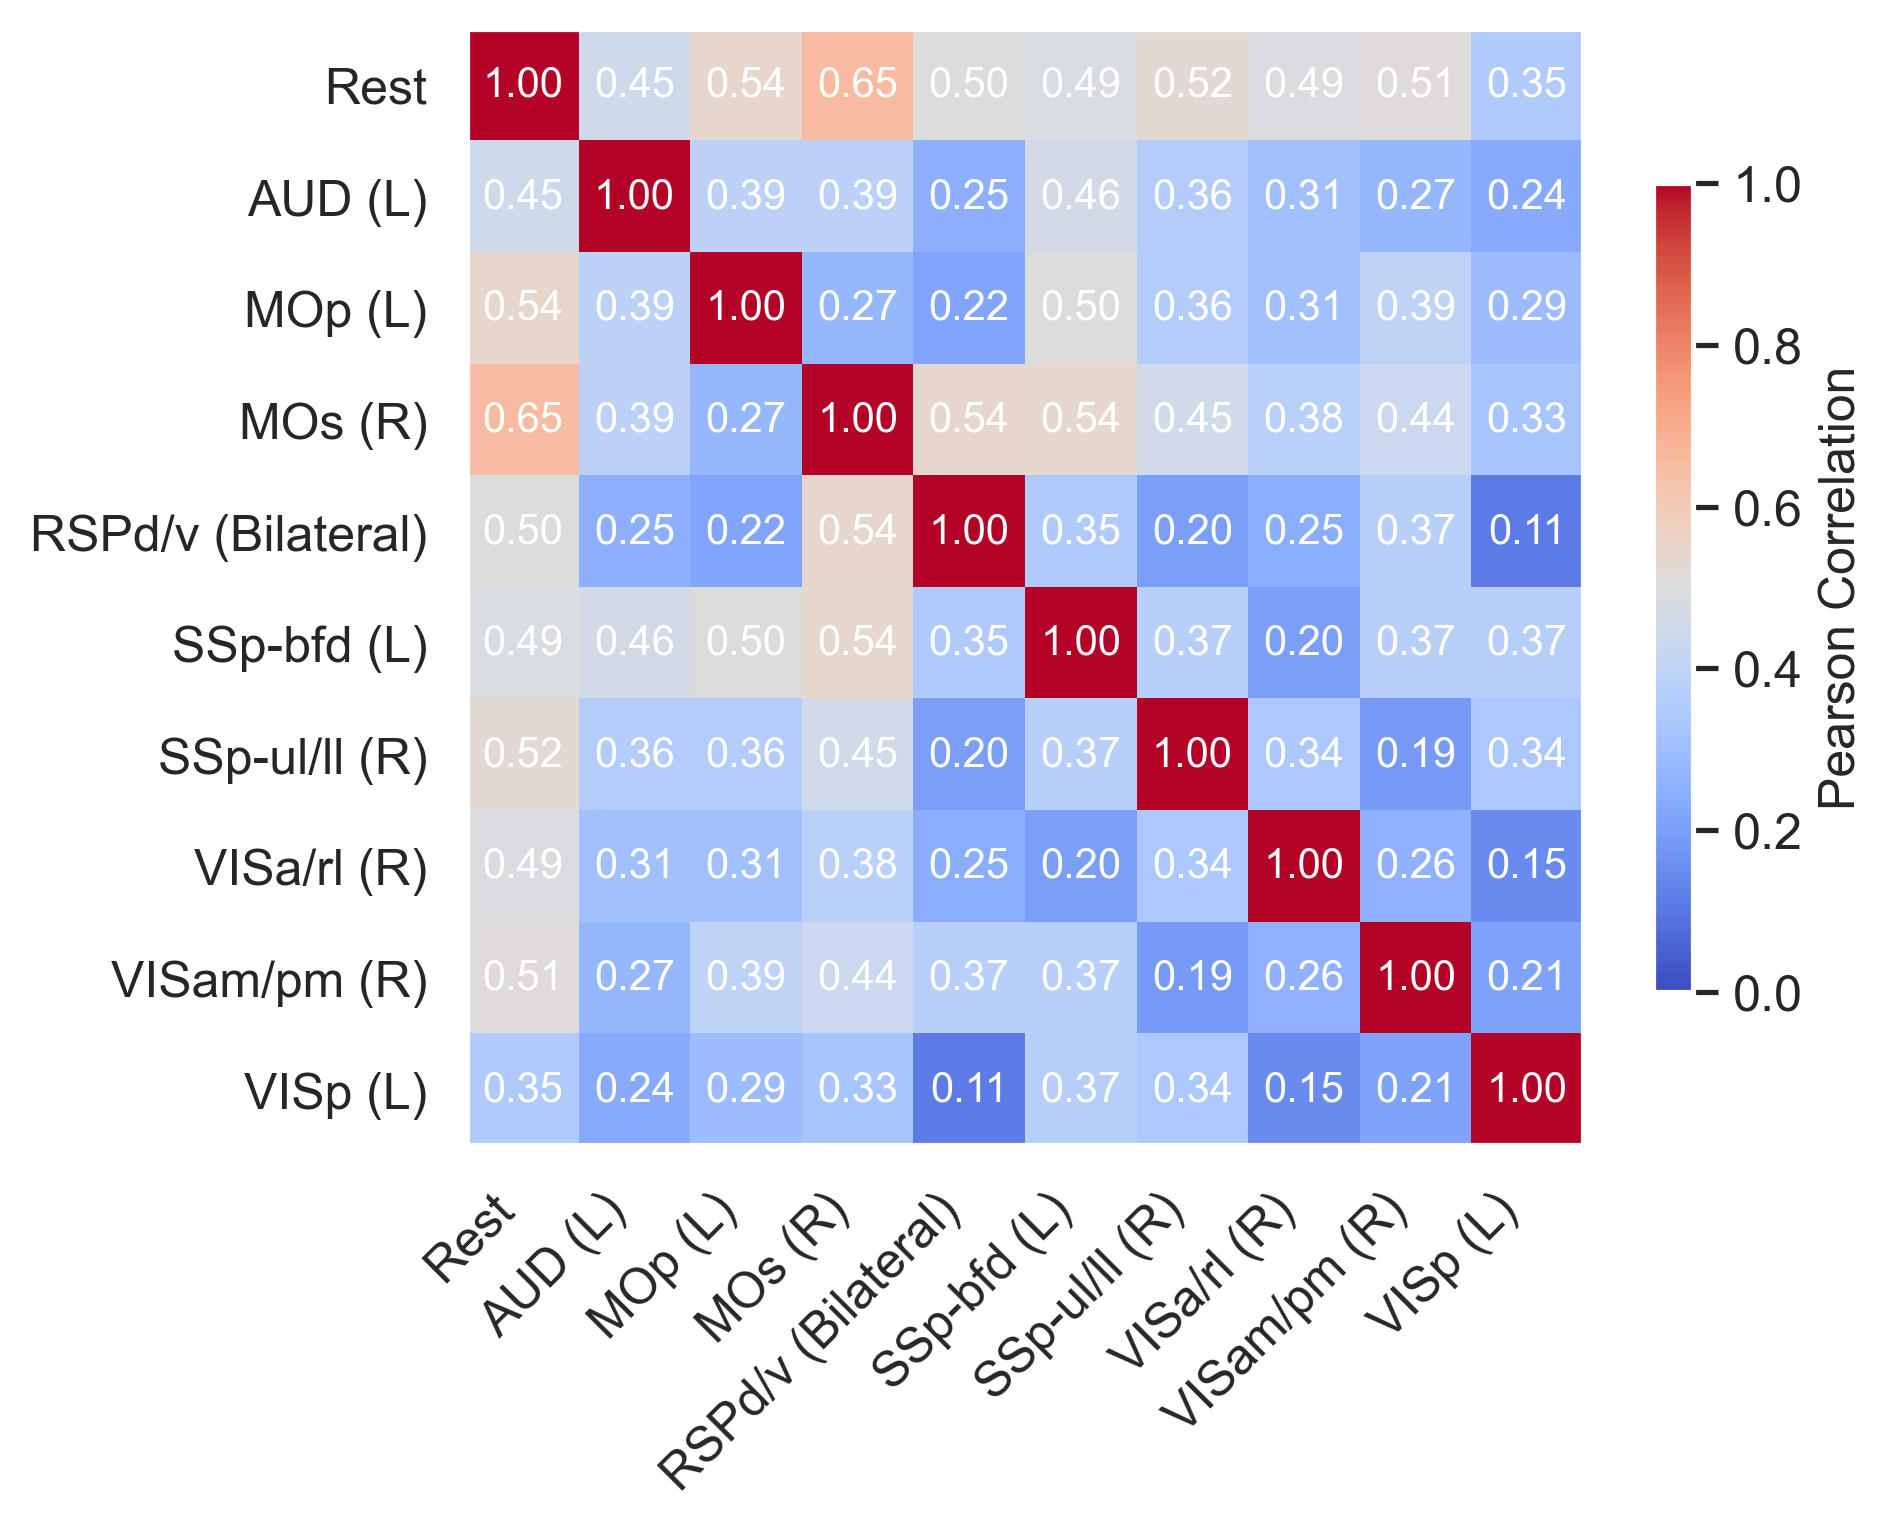

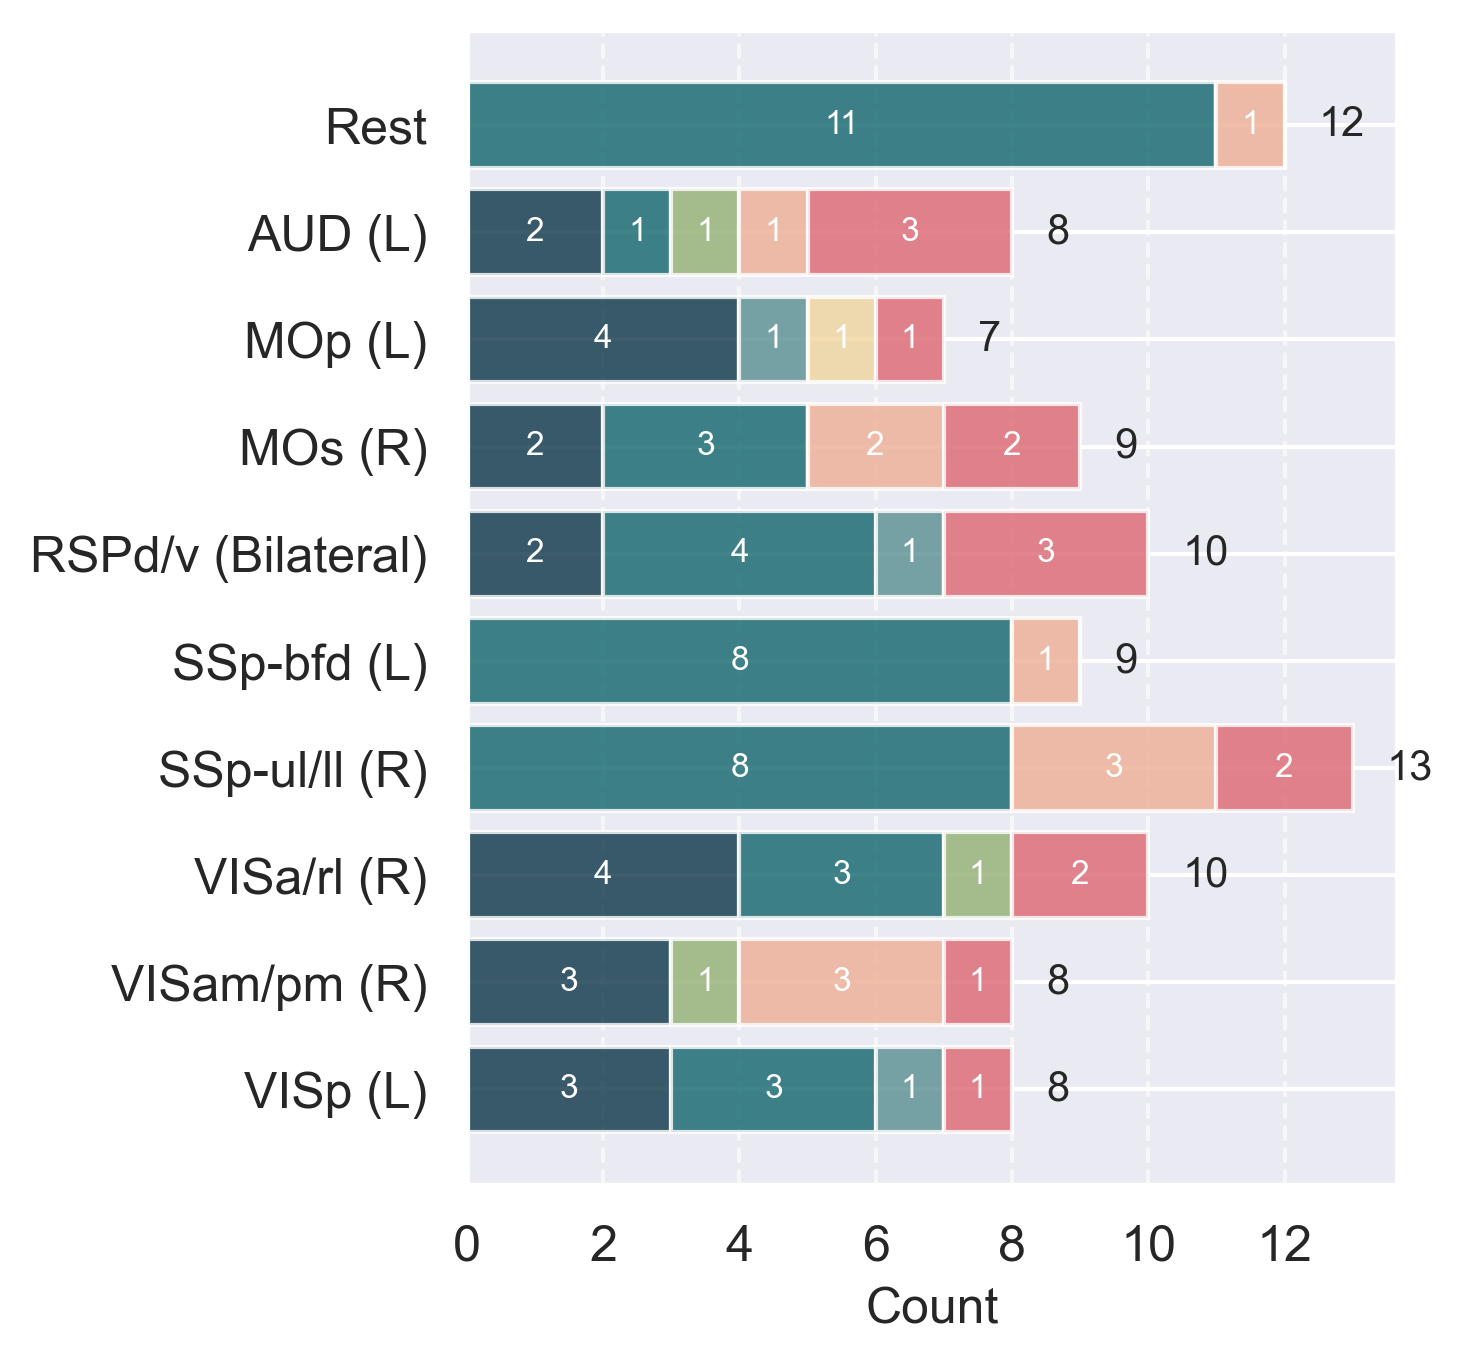

In [ ]:
plot_combined_heatmap_and_stackbar(domirank_results, key_nodes, roi_classifications)

# PID

In [ ]:
def analyze_pid_with_fixed_structure(results_folder, key_nodes, output_dir='results'):
    """
    Analyze PID data with fixed structure (supports 7 node types)
    
    Args:
        results_folder: Path containing PID results
        key_nodes: Key node classification results (7 types)
        output_dir: Output directory for saving results
        
    Returns:
        DataFrame with comparison results and DataFrame with statistical results
    """
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy import stats
    import os
    import glob
    import pickle
    import numpy as np
    
    # Prepare ROI classification mapping (7 types)
    roi_classification = {}
    for node_type in ['global_hub', 'dominant_hub', 'connector_hub', 
                     'structural_hub', 'dominant_node', 'degree_hub', 
                     'connector_node']:
        for roi_idx in key_nodes.get(node_type, set()):
            roi_classification[roi_idx] = node_type
    
    print(f"\n=== ROI Classification Mapping ===")
    print(f"Total mappings: {len(roi_classification)}")
    print("Sample entries:")
    for i, (k, v) in enumerate(list(roi_classification.items())[:5]):
        print(f"  ROI index {k}: {v}")
    
    # Load all result files
    result_files = sorted(glob.glob(os.path.join(results_folder, '*.pkl')))
    if not result_files:
        print("\nError: No .pkl files found")
        return pd.DataFrame(), pd.DataFrame()
    
    print(f"\n=== File List ===")
    print(f"Found {len(result_files)} result files")
    print("First 5 files:")
    for f in result_files[:5]:
        print(f"  {os.path.basename(f)}")
    
    # Collect all data
    all_data = []
    pid_atoms = ['R', 'U_X', 'U_Y', 'S']
    processed_pairs = 0
    skipped_pairs = 0
    
    print("\n=== Processing Files ===")
    for filepath in result_files:
        filename = os.path.basename(filepath)
        print(f"\nProcessing file: {filename}")
        
        try:
            with open(filepath, 'rb') as f:
                data = pickle.load(f)
        except Exception as e:
            print(f"  Error: Failed to load file - {str(e)}")
            continue
        
        # Get condition name
        if not data['conditions']:
            print("  Warning: No condition data found")
            continue
            
        cond_name = list(data['conditions'].keys())[0]
        cond_data = data['conditions'][cond_name]
        print(f"  Using condition: {cond_name}")
        
        if 'roi_pairs' not in cond_data:
            print("  Warning: No roi_pairs data found")
            continue
            
        roi_pairs = cond_data['roi_pairs']
        print(f"  Found {len(roi_pairs)} ROI pairs")

        for pair_key, pair_data in roi_pairs.items(): 
            if 'roi_info' not in pair_data:
                print(f"    Warning: ROI pair {pair_key} missing roi_info")
                skipped_pairs += 1
                continue
                
            roi_info = pair_data['roi_info']

            try:
                roi1_idx, roi2_idx = roi_info['indices']
                roi1_name, roi2_name = roi_info['names']
            except (KeyError, ValueError) as e:
                print(f"    Error: Failed to get ROI info - {str(e)}")
                skipped_pairs += 1
                continue
            
            # Get ROI types
            roi1_type = roi_classification.get(roi1_idx, 'normal')
            roi2_type = roi_classification.get(roi2_idx, 'normal')
            print(f"    ROI types: {roi1_name}({roi1_idx})={roi1_type}, {roi2_name}({roi2_idx})={roi2_type}")
            
            # Determine relation type (new definition: TOP if at least one is not normal)
            relation_type = 'Other-Other'
            if roi1_type != 'normal' and roi2_type != 'normal':
                relation_type = 'TOP-TOP'
            elif roi1_type != 'normal' or roi2_type != 'normal':
                relation_type = 'TOP-Other'
            print(f"    Relation type: {relation_type}")
            
            # Check PID data
            if 'PID' not in pair_data or not isinstance(pair_data['PID'], dict):
                print("    Warning: No valid PID data")
                skipped_pairs += 1
                continue
                
            pid_data = pair_data['PID'].get('mean', {})
            if not pid_data or not isinstance(pid_data, dict):
                print("    Warning: No valid PID mean data")
                skipped_pairs += 1
                continue
                
            print(f"    PID data: { {k: v for k, v in list(pid_data.items())[:3]} }...")  # Print first 3 items
            
            # Create data entry
            entry = {
                'Condition': cond_name,
                'RelationType': relation_type,
                'ROI1': roi1_name,
                'ROI2': roi2_name,
                'ROI1_Type': roi1_type,
                'ROI2_Type': roi2_type,
                **{atom: pid_data.get(atom, np.nan) for atom in pid_atoms}
            }
            
            all_data.append(entry)
            processed_pairs += 1
            print("    Entry added successfully")
    
    # Processing statistics
    print("\n=== Processing Statistics ===")
    print(f"Total processed pairs: {processed_pairs}")
    print(f"Total skipped pairs: {skipped_pairs}")
    
    if not all_data:
        print("\nError: No valid data collected")
        return pd.DataFrame(), pd.DataFrame()
        
    df = pd.DataFrame(all_data)
    print(f"\nCreated DataFrame: {len(df)} rows x {len(df.columns)} columns")
    print("Columns:", df.columns.tolist())
    
    # Statistical analysis (using new TOP definition)
    stats_results = {}
    conditions = df['Condition'].unique()
    print(f"\n=== Statistical Analysis ===")
    print(f"Conditions found: {conditions}")
    
    for atom in pid_atoms:
        if atom not in df.columns:
            print(f"  Warning: Atom {atom} not in DataFrame")
            continue
            
        print(f"\nProcessing atom: {atom}")
        cond_stats = []
        
        for cond in conditions:
            print(f"  Condition: {cond}")
            
            # New definition: TOP group includes TOP-TOP and TOP-Other
            top_data = df[(df['Condition'] == cond) & 
                         (df['RelationType'].isin(['TOP-TOP', 'TOP-Other']))][atom]
            other_data = df[(df['Condition'] == cond) & 
                           (df['RelationType'] == 'Other-Other')][atom]
            
            print(f"    TOP group samples: {len(top_data)} (includes TOP-TOP and TOP-Other)")
            print(f"    Other-Other samples: {len(other_data)}")
            
            if len(top_data) > 3 and len(other_data) > 3:
                t_stat, p_val = stats.ttest_ind(top_data, other_data, 
                                               equal_var=False, nan_policy='omit')
                
                effect_size = (np.nanmean(top_data) - np.nanmean(other_data)) / \
                             np.nanstd(np.concatenate([top_data, other_data]))
                
                cond_stats.append({
                    'Condition': cond,
                    'Atom': atom,
                    'T-statistic': t_stat,
                    'P-value': p_val,
                    'TOP_mean': np.nanmean(top_data),
                    'Other_mean': np.nanmean(other_data),
                    'TOP_std': np.nanstd(top_data),
                    'Other_std': np.nanstd(other_data),
                    'Effect_size': effect_size
                })
                
                print(f"    Results: t={t_stat:.3f}, p={p_val:.3f}, effect size={effect_size:.3f}")
            else:
                print("    Warning: Insufficient samples, skipping")
        
        if cond_stats:
            stats_results[atom] = pd.DataFrame(cond_stats)
            print(f"  Generated stats for {len(cond_stats)} conditions for atom {atom}")
    
    # Save results
    os.makedirs(output_dir, exist_ok=True)
    print(f"\n=== Saving Results ===")
    print(f"Output directory: {output_dir}")
    
    if not df.empty:
        csv_path = os.path.join(output_dir, 'pid_comparison_data2.csv')
        df.to_csv(csv_path, index=False)
        print(f"Saved comparison data to: {csv_path}")
    
    stats_dfs = []
    for atom, df_stats in stats_results.items():
        df_stats['Atom'] = atom
        stats_dfs.append(df_stats)
    
    all_stats = pd.concat(stats_dfs) if stats_dfs else pd.DataFrame()
    
    if not all_stats.empty:
        stats_path = os.path.join(output_dir, 'pid_stats_comparison2.csv')
        all_stats.to_csv(stats_path, index=False)
        print(f"Saved statistical results to: {stats_path}")
    
    print("\n=== Analysis Complete ===")
    return df, all_stats

In [ ]:
# Run the analysis
df, stats = analyze_pid_with_fixed_structure(
    results_folder='./results',
    key_nodes=key_nodes,
    output_dir='results/fixed_analysis'
)

# Display results
print("\nFinal Results:")
print("Comparison Data:")
print(df.head())

print("\nStatistical Results:")
print(stats)

In [ ]:
import pandas as pd

all_stats = pd.read_csv('pid/pid_stats_comparison2.csv')

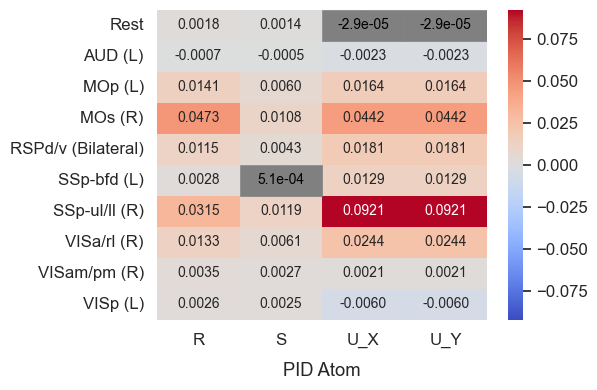

In [ ]:
def plot_difference_heatmap(stats_df, figsize=(6, 4), output_pdf=None, sig_level=0.05):
    """
    Plot difference heatmap between TOP-Other and Other-Other in similar format
    
    Parameters:
        stats_df: DataFrame containing TOP_mean and Other_mean columns
        figsize: Figure size
        output_pdf: PdfPages object to save figure
        sig_level: Significance threshold
    """
    # Calculate differences (TOP-Other minus Other-Other)
    stats_df['Difference'] = stats_df['TOP_mean'] - stats_df['Other_mean']
    
    # Create difference matrix
    diff_matrix = stats_df.pivot(index='Condition', columns='Atom', values='Difference')
    pval_matrix = stats_df.pivot(index='Condition', columns='Atom', values='P-value')
    
    # Reorder conditions to match original (with Rest first)
    conditions = ['Rest', 'AUD (L)', 'MOp (L)', 'MOs (R)', 'RSPd/v (Bilateral)', 
                'SSp-bfd (L)', 'SSp-ul/ll (R)', 'VISa/rl (R)', 'VISam/pm (R)', 'VISp (L)']
    diff_matrix = diff_matrix.reindex(conditions)
    pval_matrix = pval_matrix.reindex(conditions)

    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    max_abs = np.nanmax(np.abs(diff_matrix.values))
    
    # Create mask for non-significant values
    mask = pval_matrix >= sig_level
    
    # Plot heatmap with scientific notation
    ax = sns.heatmap(diff_matrix, cmap='coolwarm', annot=True, fmt=".4f",  # Scientific notation
                    linewidths=0, linecolor='gray',
                    vmin=-max_abs, vmax=max_abs,
                    mask=mask,
                    cbar=True)
    
    # Style non-significant cells
    for i in range(len(diff_matrix.index)):
        for j in range(len(diff_matrix.columns)):
            if mask.iloc[i, j]:
                ax.text(j + 0.5, i + 0.5, f"{diff_matrix.iloc[i, j]:.1e}", 
                       ha='center', va='center', color='black')
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, 
                                         color='gray', 
                                         linewidth=0.5))
    
    # plt.title('TOP-Other vs Other-Other Differences\n(Significant at p<0.05)', pad=20)
    plt.xlabel('PID Atom', labelpad=10)
    # plt.ylabel('Condition', labelpad=10)
    ax.set_ylabel('')

    plt.tight_layout()
    
    plt.savefig('top_diff_heatmap.pdf', bbox_inches='tight')
    plt.show()

plot_difference_heatmap(all_stats)

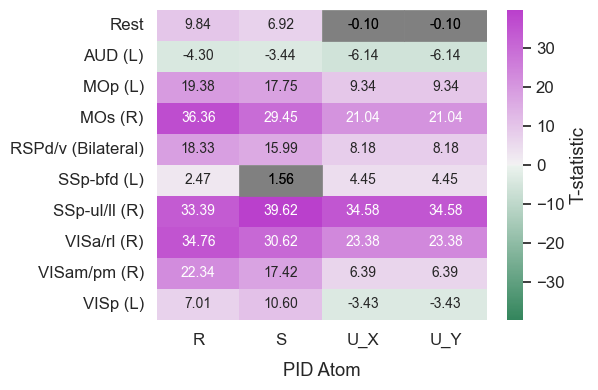

In [ ]:
def plot_t_statistic_heatmap(stats_df, figsize=(6, 4), output_pdf=None, sig_level=0.05):
    """
    Plot t-statistic heatmap with non-significant cells (p > sig_level) highlighted in gray
    
    Args:
        stats_df: DataFrame containing statistical results
        figsize: Figure dimensions (width, height)
        output_pdf: Optional PdfPages object for saving
        sig_level: Significance threshold (default 0.05)
    """
    # Create matrices for t-values and p-values
    tval_matrix = stats_df.pivot(index='Condition', columns='Atom', values='T-statistic')
    pval_matrix = stats_df.pivot(index='Condition', columns='Atom', values='P-value')
    
    # Reorder conditions with 'Rest' first if present
    conditions = tval_matrix.index.tolist()
    if 'Rest' in conditions:
        conditions.remove('Rest')
        conditions = ['Rest'] + conditions
        tval_matrix = tval_matrix.loc[conditions]
        pval_matrix = pval_matrix.loc[conditions]
    
    # Create annotation matrix showing t-values
    annot_matrix = tval_matrix.copy().astype(object)
    for i in range(len(tval_matrix.index)):
        for j in range(len(tval_matrix.columns)):
            annot_matrix.iloc[i, j] = f"{tval_matrix.iloc[i, j]:.2f}"
    
    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")
    
    # Create mask for non-significant values
    mask = pval_matrix >= sig_level
    
    # Determine color scale range
    max_abs_t = np.nanmax(np.abs(tval_matrix.values))
    cmap = sns.diverging_palette(145, 300, s=80, as_cmap=True)
    
    # Plot main heatmap
    ax = sns.heatmap(tval_matrix, cmap=cmap, annot=annot_matrix, fmt="",
                    linewidths=0, linecolor='gray', 
                    center=0,
                    vmin=-max_abs_t, vmax=max_abs_t,
                    cbar_kws={'label': 'T-statistic'})
    
    # Highlight non-significant cells with gray background
    for i in range(len(tval_matrix.index)):
        for j in range(len(tval_matrix.columns)):
            if mask.iloc[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, 
                                         color='grey',
                                         linewidth=0.5,
                                         linestyle='-'))
                ax.text(j + 0.5, i + 0.5, f"{tval_matrix.iloc[i, j]:.2f}",
                       ha='center', va='center', color='black', fontweight='normal')
    
    plt.xlabel('PID Atom', labelpad=10)
    ax.set_ylabel('')

    plt.tight_layout()
    
    if output_pdf:
        output_pdf.savefig(bbox_inches='tight')
    plt.savefig('t_statistic_heatmap.pdf', bbox_inches='tight')
    plt.show()

plot_t_statistic_heatmap(all_stats)